In [1]:
# define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.Notebook_imports import *
#from pyforest import *
from src.utils.Tensorflow_helper import choose_gpu_by_id
from tensorflow.keras.utils import plot_model

# define GPU id to use
GPU_IDS = '0,1'
GPUS = choose_gpu_by_id(GPU_IDS)
print(GPUS)

# jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# import helpers
from src.utils.Utils_io import Console_and_file_logger, init_config
from src.visualization.Visualize import show_2D_or_3D
from src.data.Dataset import get_img_msk_files_from_split_dir, load_acdc_files, get_train_data_from_df, get_trainings_files
from src.data.Generators import DataGenerator, get_samples
#from src.utils.unet_3d_metrics import weighted_dice_coefficient_loss
from src.utils.KerasCallbacks import get_callbacks
import cv2
import tensorflow as tf
from tensorflow.keras.losses import mse
import src.utils.Metrics_own as metr
import src.models.SpatialTransformer as st
from src.models.SpatialTransformer import  create_affine_cycle_transformer_model


# define experiment name for report, model and log paths + filenames
EXPERIMENT = '3D/ax_sax/unetwithdownsamplingaugmentation'
now = datetime.datetime.now()
# image params, change for different input data/architecture
ARCHITECTURE = '3D' # 2D
# path params
DATASET = 'GCN'  # 'acdc' # or 'gcn'
TRAIN_PATH = 'data/raw/{}/{}/train/'.format(DATASET, ARCHITECTURE)
VAL_PATH = 'data/raw/{}/{}/val/'.format(DATASET, ARCHITECTURE)
TEST_PATH = 'data/raw/{}/{}/val/'.format(DATASET, ARCHITECTURE)
#DF_DATA_PATH = 'data/raw/{}/{}/df_kfold.csv'.format(DATASET, ARCHITECTURE)
#DF_DATA_PATH = 'data/raw/miccai2020/2d_dataset.csv' # miccai special case
DATA_PATH = '/mnt/ssd/git/3d-mri-domain-adaption/data/raw/gcn_05_2020_ax_sax_86/AX_3D_ISO/'
FOLD = 0

MODEL_PATH = os.path.join('models', EXPERIMENT, str(now.strftime("%Y-%m-%d_%H_%M")))
TENSORBOARD_LOG_DIR = os.path.join('reports/tensorboard_logs', EXPERIMENT,str(now.strftime("%Y-%m-%d_%H_%M")))
CONFIG_PATH = os.path.join('reports/configs/',EXPERIMENT,str(now.strftime("%Y-%m-%d_%H_%M")))
HISTORY_PATH = os.path.join('reports/history/',EXPERIMENT,str(now.strftime("%Y-%m-%d_%H_%M")))

DIM = [64, 112, 112] # network input params for spacing of 5
#DIM = [64, 112, 112]
DEPTH = 4 # number of down-/upsampling blocks
FILTERS = 16 # initial number of filters, will be doubled after each downsampling block
#SPACING = [8,1.1, 1,1] # used by sitk, order will be reversed to have the same shape as dim
SPACING = [3,3, 3] # if resample, resample to this spacing
M_POOL = [2, 2, 2]# used for downsampling and upsampling
F_SIZE = [3, 3, 3] # conv filter size
IMG_CHANNELS = 1
MASK_VALUES = [1, 2, 3]  #channel order: Background, RV, MYO, LV
MASK_CLASSES = len(MASK_VALUES) # no of labels
BORDER_MODE = cv2.BORDER_REFLECT_101
IMG_INTERPOLATION = cv2.INTER_LINEAR
MSK_INTERPOLATION = cv2.INTER_NEAREST
AUGMENT = False
SHUFFLE = True
AUGMENT_GRID = False
RESAMPLE = True
SCALER = 'MinMax' # MinMax Standard or Robust

AX_LOSS_WEIGHT = 1.0
WEIGHT_MSE_INPLANE = False
MASK_SMALLER_THAN_THRESHOLD = 0.01

SAX_LOSS_WEIGHT = 1.0
CYCLE_LOSS = True

FOCUS_LOSS_WEIGHT = 1.0
FOCUS_LOSS = True
USE_SAX2AX_PROB = True
MIN_UNET_PROBABILITY = 0.9

# training params
#GENERATOR_WORKER = 6# if not set, use batchsize
SEED = 42 # define a seed for the generator shuffle
BATCHSIZE = 2 # 32, 64, 24, 16, 1 for 3D use: 8
INITIAL_EPOCH = 0 # change this to continue training
EPOCHS = 300 # define a maximum numbers of epochs
EPOCHS_BETWEEN_CHECKPOINTS = 5
MONITOR_FUNCTION = 'val_loss'
MONITOR_MODE = 'min'
SAVE_MODEL_FUNCTION = 'val_loss'
SAVE_MODEL_MODE = 'min'
MODEL_PATIENCE = 20
BN_FIRST = False # decide if BN between Conv and activation or afterwards
BATCH_NORMALISATION = True # apply BN or not
USE_UPSAMPLE = True # otherwise use transpose
PAD = 'same' # padding strategy
KERNEL_INIT = 'he_normal' # conv weight initialisation
OPTIMIZER = 'adam' # Adam, Adagrad, RMSprop, Adadelta,  # https://keras.io/optimizers/
ACTIVATION = 'elu' # tf.keras.layers.LeakyReLU(), relu, any non linear activation function
LEARNING_RATE = 1e-4 # start with a huge lr to converge fast
DECAY_FACTOR = 0.3 # Define a learning rate decay for the ReduceLROnPlateau callback
MIN_LR = 1e-10 # smaller lr does not improve the model
DROPOUT_min = 0.3 # lower dropout at the shallow layers
DROPOUT_max = 0.5 # higher dropout at the deep layers

metrics = [
    metr.dice_coef_labels,
    metr.dice_coef_myo,
    metr.dice_coef_lv,
    metr.dice_coef_rv
]

#MASKING_VALUES = [2]
#MASKING_IMAGE = False

LOSS_FUNCTION = metr.bce_dice_loss
#LOSS_FUNCTION = metr.jaccard_distance_loss
#LOSS_FUNCTION = metr.bce_dice_jac_loss

Console_and_file_logger(EXPERIMENT, logging.INFO)

# Define a config for param injection,
# save a serialized version, 
# make sure all paths exist
config = init_config(config=locals(), save=True)
print(config)

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/3d-mri-domain-adaption


2020-11-20 09:20:39,200 INFO -------------------- Start --------------------
2020-11-20 09:20:39,201 INFO Working directory: /mnt/ssd/git/3d-mri-domain-adaption.
2020-11-20 09:20:39,201 INFO Log file: ./logs/3D/ax_sax/unetwithdownsamplingaugmentation.log
2020-11-20 09:20:39,201 INFO Log level for console: INFO


['/gpu:0', '/gpu:1']
{'GPU_IDS': '0,1', 'GPUS': ['/gpu:0', '/gpu:1'], 'EXPERIMENT': '3D/ax_sax/unetwithdownsamplingaugmentation', 'ARCHITECTURE': '3D', 'DATASET': 'GCN', 'TRAIN_PATH': 'data/raw/GCN/3D/train/', 'VAL_PATH': 'data/raw/GCN/3D/val/', 'TEST_PATH': 'data/raw/GCN/3D/val/', 'DATA_PATH': '/mnt/ssd/git/3d-mri-domain-adaption/data/raw/gcn_05_2020_ax_sax_86/AX_3D_ISO/', 'FOLD': 0, 'MODEL_PATH': 'models/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-20_09_20', 'TENSORBOARD_LOG_DIR': 'reports/tensorboard_logs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-20_09_20', 'CONFIG_PATH': 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-20_09_20', 'HISTORY_PATH': 'reports/history/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-20_09_20', 'DIM': [64, 112, 112], 'DEPTH': 4, 'FILTERS': 16, 'SPACING': [3, 3, 3], 'M_POOL': [2, 2, 2], 'F_SIZE': [3, 3, 3], 'IMG_CHANNELS': 1, 'MASK_VALUES': [1, 2, 3], 'MASK_CLASSES': 3, 'BORDER_MODE': 4, 'IMG_INTERPOLATION': 1, 'MSK_INT

In [2]:
tf.test.is_built_with_cuda()
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
# Load AX slices

from src.data.Generators import MotionDataGenerator, CycleMotionDataGenerator
info = {}

x_train_ax, y_train_ax, x_val_ax, y_val_ax =  get_trainings_files(data_path=DATA_PATH,fold=FOLD)
config.update(info)
config = init_config(config)

logging.info('x_train files: {}, y_train files: {}'.format(len(x_train_ax), len(y_train_ax)))
logging.info('x_val files: {}, y_val files: {}'.format(len(x_val_ax), len(y_val_ax)))

In [ ]:
# load SAX slices
DATA_PATH_SAX = DATA_PATH.replace('AX_3D_ISO', 'AX_to_SAX_3D_ISO_SHIFT')
#DATA_PATH_SAX = 'data/interim/sax_ax_3d_thres_50_max/ax_to_sax'
x_train_sax, y_train_sax, x_val_sax, y_val_sax =  get_trainings_files(data_path=DATA_PATH_SAX,fold=FOLD)
config.update(info)
config = init_config(config)

logging.info('x_train files: {}, y_train files: {}'.format(len(x_train_sax), len(y_train_sax)))
logging.info('x_val files: {}, y_val files: {}'.format(len(x_val_sax), len(y_val_sax)))

from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

In [ ]:
print('ax examples: {}'.format(x_val_ax[:2]))
#print('sax_examples: {}'.format(x_train_sax[:2]))

In [ ]:
# filter files by name
#x_val_ax = [x for x in x_val_ax if '4A4PVCYL_2006' in x]
#x_val_sax = [x for x in x_val_sax if '4A4PVCYL_2006' in x]
#y_val_ax = [x for x in y_val_ax if '4A4PVCYL_2006' in x]
print(len(x_val_ax))
print(len(x_val_sax))
print(len(y_val_ax))

In [ ]:
# config['BATCHSIZE'] = 32 # debug
batch_generator = CycleMotionDataGenerator(x_train_ax, x_train_sax, config)
valid_config = config.copy()
valid_config['AUGMENT_GRID'] = False
valid_generator = CycleMotionDataGenerator(x_val_ax, x_val_sax, valid_config)

In [9]:
# Select batch generator output
x = ''
y = ''
@interact
def select_batch(batch = (0,len(valid_generator), 1)):
    global x, y, x2, y2
    input_ , output_ = valid_generator.__getitem__(batch)
    x = input_[0]
    y = output_[0]
    x2 = input_[1]
    y2 = output_[1]
    logging.info('input elements: {}'.format(len(input_)))
    logging.info('output elements: {}'.format(len(output_)))
    logging.info(x.shape)
    logging.info(y.shape)
    logging.info(x2.shape)
    logging.info(y2.shape)

interactive(children=(IntSlider(value=10, description='batch', max=21), Output()), _dom_classes=('widget-inter…

In [10]:
@interact
def select_image_in_batch(im = (0,x.shape[0]- 1, 1),slice_by=(1,6)):
    
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.DEBUG)
    temp_dir = 'reports/figures/temp/'
    ensure_dir(temp_dir)

    logging.info('AX: {}'.format(x[im].shape))
    show_2D_or_3D(x[im][...,0][::slice_by])
    plt.savefig(os.path.join(temp_dir,'ax.pdf'))
    plt.show()
    logging.info('AXtoSAX: {}'.format(y[im].shape))
    show_2D_or_3D(y[im][...,0][::slice_by])
    plt.savefig(os.path.join(temp_dir,'ax2sax.pdf'))
    plt.show()
    logging.info('SAX: {}'.format(x2[im].shape))
    show_2D_or_3D(x2[im][...,0][::slice_by])
    plt.savefig(os.path.join(temp_dir,'sax.pdf'))
    plt.show()
    logging.info('SAXtoAX: {}'.format(y2[im].shape))
    show_2D_or_3D(y2[im][...,0][::slice_by])
    plt.savefig(os.path.join(temp_dir,'sax2ax.pdf'))
    plt.show()
    

interactive(children=(IntSlider(value=0, description='im', max=1), IntSlider(value=3, description='slice_by', …

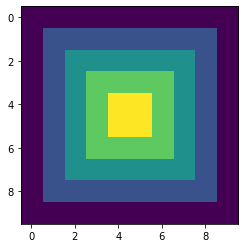

[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.  ]
 [0.   0.25 0.5  0.5  0.5  0.5  0.5  0.5  0.25 0.  ]
 [0.   0.25 0.5  0.75 0.75 0.75 0.75 0.5  0.25 0.  ]
 [0.   0.25 0.5  0.75 1.   1.   0.75 0.5  0.25 0.  ]
 [0.   0.25 0.5  0.75 1.   1.   0.75 0.5  0.25 0.  ]
 [0.   0.25 0.5  0.75 0.75 0.75 0.75 0.5  0.25 0.  ]
 [0.   0.25 0.5  0.5  0.5  0.5  0.5  0.5  0.25 0.  ]
 [0.   0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]]


In [11]:
import numpy as np
x_shape = 10
y_shape = 10
temp = np.zeros((x_shape, y_shape))
weights_distribution = np.linspace(0, 1, x_shape // 2)
for i, l in enumerate(weights_distribution):
    temp[i:-i, i:-i] = l
plt.imshow(temp)
plt.show()
print(temp)

In [12]:
# 2D unet
"""
load past config for model training 
"""
if 'strategy' in globals():
    pass
else:
    # distribute the training with the mirrored data paradigm across multiple gpus if available, if not use gpu 0
    strategy = tf.distribute.MirroredStrategy(devices=config.get('GPUS', ["/gpu:0"]))
tf.print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
if 'config_chooser' in locals():
    config_file  = config_chooser.selected
else:
    #config_file = '/mnt/data/git/cardio/reports/configs/3D/wrapper/gcn_and_acdc_exlusive_ax/2020-07-23_20_49/config.json'
    #config_file = '/mnt/ssd/git/3d-mri-domain-adaption/reports/configs/2D/gcn_and_acdc_excl_ax/config.json' # config for TMI paper
    config_file = '/mnt/ssd/git/cardio/reports/configs/2D/gcn_05_2020_sax_excl_ax_patients/2020-11-13_12_09/config.json' # retrained with downsampling
load = True # change to false, if this pipeline is used without finetuning
# load config with all params into global namespace
from src.models.ModelUtils import load_pretrained_model
if load: # load pretrained model
    with open(config_file, encoding='utf-8') as data_file:
        config_temp = json.loads(data_file.read())
    config_temp['LOSS_FUNCTION'] = config['LOSS_FUNCTION']
    logging.info('Load model from Experiment: {}'.format(config_temp['EXPERIMENT']))
    #logging.info('config:\n {}'.format(json.dumps(config, indent=4, sort_keys=True)))

    try:
        with strategy.scope():
            globals()['unet'] = load_pretrained_model(config_temp, metrics, comp=False)
            #globals()['unet'].summary()
    except Exception as e:
        logging.error(str(e))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:20:42,952 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


Number of devices: 2


2020-11-20 09:20:43,025 INFO Load model from Experiment: 2D/gcn_05_2020_sax_excl_ax_patients
2020-11-20 09:20:43,026 INFO load model with keras api
2020-11-20 09:20:45,396 INFO Unable to restore custom object of type _tf_keras_metric currently. Please make sure that the layer implements `get_config`and `from_config` when saving. In addition, please use the `custom_objects` arg when calling `load_model()`.
2020-11-20 09:20:45,397 INFO Keras API failed, use json repr. load model from: models/2D/gcn_05_2020_sax_excl_ax_patients/2020-11-13_12_09/model.json .
2020-11-20 09:20:45,398 INFO loading model description


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2020-11-20 09:20:45,471 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2020-11-20 09:20:45,474 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2020-11-20 09:20:45,478 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2020-11-20 09:20:45,482 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2020-11-20 09:20:45,491 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2020-11-20 09:20:45,494 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2020-11-20 09:20:45,522 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2020-11-20 09:20:45,525 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2020-11-20 09:20:45,529 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2020-11-20 09:20:45,531 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
2020-11-20 09:20:46,252 INFO loading model weights
2020-11-20 09:20:46,415 INFO model models/2D/gcn_05_2020_sax_excl_ax_patients/2020-11-13_12_09/model.json loaded


In [13]:
if 'strategy' in globals():
    pass
else:
    # distribute the training with the mirrored data paradigm across multiple gpus if available, if not use gpu 0
    strategy = tf.distribute.MirroredStrategy(devices=config.get('GPUS', ["/gpu:0"]))
with strategy.scope():
    model = st.create_affine_cycle_transformer_model(config=config, metrics=metrics, unet=locals().get('unet', None))

Number of devices: 2
Instructions for updating:
Use fn_output_signature instead


2020-11-20 09:20:47,517 WARNING From /home/sven/anaconda3/envs/ax2sax/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py:574: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Use fn_output_signature instead
2020-11-20 09:20:48,780 INFO unet given, use it to max probability
2020-11-20 09:21:03,394 INFO adding ax2sax MSE loss with a weighting of 1.0
2020-11-20 09:21:03,394 INFO adding cycle loss with a weighting of 1.0
2020-11-20 09:21:03,395 INFO adding focus loss on mask2ax with a weighting of 1.0


In [14]:
model.summary(line_length=150)
#plot_model(model, to_file='reports/figures/temp_graph.pdf',show_shapes=True)

Model: "affine_cycle_transformer"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_1 (InputLayer)                             [(None, 64, 112, 112, 1)]        0                                                                   
______________________________________________________________________________________________________________________________________________________
conv_encoder (ConvEncoder)                       ((None, 4, 7, 7, 256), [(None, 6 3537424           input_1[0][0]                                     
______________________________________________________________________________________________________________________________________________________
global_average_pooling3d (GlobalAveragePooling3D (None, 256)

In [15]:
@interact
def select_image_in_batch(im = (0,x.shape[0]- 1, 1),mask_smaller_than='0.01', slice_by=(1,6)):
    global m
    import numpy as np
    temp = x[im]
    sax = x2[im]
    temp_ = y[im]
    
    mask = temp_ >float(mask_smaller_than)
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.INFO)
    logging.info('prediction on: {}'.format(temp.shape))
    show_2D_or_3D(temp[::slice_by])
    plt.show()
    pred, inv_pred, ax2sax_mod, prob, ax_msk,m, m_mod = model.predict(x = [np.expand_dims(temp,axis=0),np.expand_dims(sax,axis=0)])                     
    logging.info('rotated by the model: {}'.format(pred[0].shape))
    show_2D_or_3D(pred[0][::slice_by], mask[::slice_by])
    plt.show()
    logging.info('inverse rotation on SAX: {}'.format(inv_pred[0].shape))
    show_2D_or_3D(inv_pred[0][::slice_by])
    plt.show()
    logging.info('predicted mask: {}'.format(inv_pred[0].shape))
    show_2D_or_3D(prob[0][::slice_by])
    plt.show()
    logging.info('predicted mask in ax: {}'.format(ax_msk[0].shape))
    show_2D_or_3D(ax_msk[0][::slice_by])
    plt.show()
    
    # calculate the loss mask from target AX2SAX image
    mask = temp_ >float(mask_smaller_than)
    logging.info('masked by GT: {}'.format(mask.shape))
    masked = pred[0] * mask
    show_2D_or_3D(masked[::slice_by], mask[::slice_by])
    plt.show()
    logging.info('target (AX2SAX): {}'.format(temp_.shape))
    show_2D_or_3D(temp_[::slice_by])
    plt.show()
    logging.info('Created MSE mask by thresholding the target (AX2SAX) with {}: {}'.format(mask_smaller_than,temp_.shape))
    show_2D_or_3D(mask[::slice_by])
    plt.show()
    logging.info('MSE: {}'.format(mse(pred[0], temp_).numpy().mean()))
    logging.info('prob loss: {}'.format(metr.max_volume_loss(min_probabillity=0.5)(temp_[tf.newaxis,...],prob).numpy().mean()))
    try:
        print(np.reshape(m[0],(3,4)))
        print(np.reshape(m_mod[0],(3,4)))
    except Exception as e:
        pass

interactive(children=(IntSlider(value=0, description='im', max=1), Text(value='0.01', description='mask_smalle…

In [ ]:
# train one model
initial_epoch = 0
# training

# start a new main process for this training to free gpu memory afterwards
logging.info('Fit model, start trainings process')
# fit model with trainingsgenerator
results = model.fit(
    x=batch_generator,
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    epochs=200,
    callbacks = get_callbacks(config, valid_generator),
    steps_per_epoch = len(batch_generator),
    initial_epoch=initial_epoch,
    #max_queue_size=24,
    #workers=10,
    verbose=1)

2020-11-20 09:21:48,396 INFO Fit model, start trainings process


Epoch 1/200
INFO:tensorflow:batch_all_reduce: 44 all-reduces with algorithm = nccl, num_packs = 1


2020-11-20 09:22:36,648 INFO batch_all_reduce: 44 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 44 all-reduces with algorithm = nccl, num_packs = 1


2020-11-20 09:23:20,063 INFO batch_all_reduce: 44 all-reduces with algorithm = nccl, num_packs = 1


 1/60 [..............................] - ETA: 0s - loss: 5.0443 - ax2sax_loss: 2.1770 - sax2ax_loss: 1.8784 - mask2ax_loss: 0.9889WARNING:tensorflow:From /home/sven/anaconda3/envs/ax2sax/lib/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


2020-11-20 09:24:20,289 WARNING From /home/sven/anaconda3/envs/ax2sax/lib/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


60/60 [==============================] - ETA: 0s - loss: 4.8411 - ax2sax_loss: 2.0819 - sax2ax_loss: 1.7690 - mask2ax_loss: 0.9903
Epoch 00001: val_loss improved from inf to 4.88826, saving model to models/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-20_09_20/model.h5
60/60 [==============================] - 135s 2s/step - loss: 4.8411 - ax2sax_loss: 2.0819 - sax2ax_loss: 1.7690 - mask2ax_loss: 0.9903 - val_loss: 4.8883 - val_ax2sax_loss: 2.0300 - val_sax2ax_loss: 1.8670 - val_mask2ax_loss: 0.9913 - lr: 1.0000e-04
Epoch 2/200
60/60 [==============================] - ETA: 0s - loss: 4.7705 - ax2sax_loss: 2.0357 - sax2ax_loss: 1.7432 - mask2ax_loss: 0.9916
Epoch 00002: val_loss did not improve from 4.88826
60/60 [==============================] - 95s 2s/step - loss: 4.7705 - ax2sax_loss: 2.0357 - sax2ax_loss: 1.7432 - mask2ax_loss: 0.9916 - val_loss: 4.8912 - val_ax2sax_loss: 2.0291 - val_sax2ax_loss: 1.8711 - val_mask2ax_loss: 0.9909 - lr: 1.0000e-04
Epoch 3/200
60/60 [===========

In [ ]:
#tf.keras.models.save_model(model,filepath=config['MODEL_PATH'],overwrite=True,include_optimizer=False,save_format='tf')

In [ ]:
config['MODEL_PATH']

In [17]:
# load pre-trained AXtoSAX rotation model

"""
load past config for model training 
"""
if 'strategy' in locals():
    pass
else:
    # distribute the training with the mirrored data paradigm across multiple gpus if available, if not use gpu 0
    strategy = tf.distribute.MirroredStrategy(devices=config.get('GPUS', ["/gpu:0"]))
#config_file  = 'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_inplaneweight_l3_0_2_1weights/2020-07-24_08_29/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_inplaneweight_l3_0_2_1weights/2020-07-24_10_30/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_inplaneweight_l3_0_2_1weights/2020-07-24_11_59/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_inplaneweight_l3_0_2_1weights/2020-07-24_13_34/config.json'

#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_NOinplaneweight_l3_0_2_1weights/2020-07-25_11_04/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_NOinplaneweight_l3_0_2_1weights/2020-07-26_10_24/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_NOinplaneweight_l3_0_2_1weights/2020-07-26_14_59/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_NOinplaneweight_l3_0_2_1weights/2020-07-26_16_27/config.json'

#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_NOmasked_inplaneweight_l3_0_2_1weights/2020-07-26_20_53/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_NOmasked_inplaneweight_l3_0_2_1weights/2020-07-26_22_26/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_NOmasked_inplaneweight_l3_0_2_1weights/2020-07-27_08_08/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_NOmasked_inplaneweight_l3_0_2_1weights/2020-07-27_09_23/config.json'

# Full 4folds
#config_file = 'reports/configs/3D/ax_sax/full/temp/2020-08-04_14_04/config.json'
#config_file = 'reports/configs/3D/ax_sax/full/baseline_unet_cycle/2020-08-04_16_45/config.json' # fold0, guter Fold
#config_file = 'reports/configs/3D/ax_sax/full/baseline_unet_cycle/2020-08-04_23_22/config.json' # fold2
#config_file = 'reports/configs/3D/ax_sax/full/baseline_unet_cycle/2020-08-05_08_42/config.json' # fold1, guter Fold
#config_file = 'reports/configs/3D/ax_sax/full/temp/2020-08-05_17_52/config.json' # fold3 2nd, guter Fold

# baseline_cycle fold 0 - did not converge in most of the folds
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-05_21_30/config.json'
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-05_22_22/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-05_23_06/config.json'

# baseline_cycle
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-06_08_29/config.json' # fold0
# baseline_cycle Fold 1 did not converge, with this modification it learnt very well:  with 96 x 224 x 224 and inplane weighting
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-06_12_48/config.json' # fold 1
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-06_14_54/config.json' # fold 2
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-06_16_17/config.json' # fold 3

# full model with inplane
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle_unet/2020-08-07_00_31/config.json' # fold 0
# fold 1 repeat, looks good 3D/ax_sax/full/baseline_cycle_unet/2020-08-07_16_42/
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle_unet/2020-08-07_07_51/config.json' # fold 1
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle_unet/2020-08-07_11_42/config.json' # fold 3, did not work
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle_unet/2020-08-07_18_28/config.json' # fold 3
# on downsampled images
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle_unet/2020-08-08_07_37/config.json' Fold 2
#config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-08_16_20/config.json' Fold 0
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-08_21_15/config.json' Fold 1

# baseline_unet
#config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-08_10_20/config.json' # fold 0
#config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-08_11_34/config.json' # fold 1
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-08_15_23/config.json' fold 2
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-08_13_02/config.json' # fold 3

# full model, with inplane and 128
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-10_16_24/config.json' # fold 0
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-10_18_38/config.json' #fold 1
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-12_11_53/config.json' # fold 2
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-12_12_57/config.json'# fold3

# temp
#config_file = 'reports/configs/3D/ax_sax/weighting/1_ax_1_sax_1_unet/2020-09-30_18_31/config.json'
#config_file = 'reports/configs/3D/ax_sax/weighting/mask_prob_1_ax_1_sax_1_unet/2020-10-01_10_13/config.json'
#config_file = 'reports/configs/3D/ax_sax/weighting/mask_prob_2_ax_2_sax_1_mask2ax_unet/2020-10-01_15_05/config.json'
# config_file = 'reports/configs/3D/ax_sax/weighting/1_ax_1_sax_2_mask2ax_unet/2020-10-01_16_17/config.json'

# Repeat full model on all folds with: weighting mask 1, ax 2, sax 2 (cycle, probability and inplane weighting)
# saved as mask2ax 1_ax_2_sax_2_full_post
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax 1_ax_2_sax_2_full/2020-10-13_17_57/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_2_sax_2_full/2020-10-14_09_32/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_2_sax_2_full/2020-10-14_11_24/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_2_sax_2_full/2020-10-14_16_02/config.json' # Fold 3


# Repeat full model on all folds with: weighting mask 1, ax 10, sax 10 (cycle, probability and inplane weighting)
# saved as mask2ax 1_ax_10_sax_10_full_post
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_10_sax_10_full/2020-10-14_23_10/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_10_sax_10_full/2020-10-15_08_48/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_10_sax_10_full/2020-10-15_10_44/config.json' # Fold 2 
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_10_sax_10_full/2020-10-15_09_45/config.json' # Fold 3

#Use the SAX probability for the focus_loss instead of the SAX2AX probability
#config_file = 'reports/configs/3D/ax_sax/weighting/masksax_1_ax_10_sax_10_ax_loss/2020-10-16_10_37/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/weighting/masksax_1_ax_10_sax_10_ax_loss/2020-10-16_12_37/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/weighting/masksax_1_ax_10_sax_10_ax_loss/2020-10-16_13_15/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/weighting/masksax_1_ax_10_sax_10_ax_loss/2020-10-16_15_27/config.json' # Fold 3


# Basline model with AX MSE as loss and inplane weighting
# saved as mask2ax0_ax1_sax0_baseline_post
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_0_ax_1_sax_0_ax_loss/2020-10-15_14_50/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_0_ax_1_sax_0_ax_loss/2020-10-15_16_39/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_1_sax_0_ax_loss/2020-10-19_09_42/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_1_sax_0_ax_loss/2020-10-19_10_37/config.json' # Fold 3

# Basline model with inplane and bool loss switches
# saved as mask2ax0_ax1_sax0_baseline_post
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_inplane_fold0/2020-10-19_14_47/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_inplane_fold1/2020-10-19_15_18/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_inplane_fold2/2020-10-19_18_14/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_inplane_fold3/2020-10-19_18_49/config.json' # Fold 3 # did not converge, which is ok and a problem of the baseline

# Baseline model without inplane and bool loss switches
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_NOinplane_fold0/2020-10-20_08_55/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_NOinplane_fold1/2020-10-20_09_20/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_NOinplane_fold2/2020-10-20_09_49/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_NOinplane_fold3/2020-10-20_10_16/config.json' # Fold 3

# Baseline model with inplane and focus loss on sax masks
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_1focus_inplane_fold0/2020-10-20_12_04/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_1focus_inplane_fold1/2020-10-20_13_17/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_1focus_inplane_fold2/2020-10-20_13_44/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_1focus_inplane_fold3/2020-10-20_15_32/config.json' # Fold 3


# new cropping = no square cropping before resampling and crop or pad
# --> 'data/predicted/papernewcrop_baseline_1ax_1sax_01focus_inplane/3D/'
# Baseline model with inplane 1cycle and 0.1focus loss on sax masks 
#/3D/ax_sax/paper/baseline_1ax_1sax_1focus_inplane_fold0/2020-10-21_15_45/
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_1focus_inplane_fold0/2020-10-21_15_45/config.json' # Fold 0 # new cropping
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_1focus_inplane_fold1/2020-10-21_17_31/config.json' # Fold 1 # new cropping
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_1focus_inplane_fold2/2020-10-21_19_04/config.json' # Fold 2 # new cropping
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_1focus_inplane_fold3/2020-10-21_22_48/config.json' # Fold 3 # new cropping


# Baseline model with inplane and cycle loss weighting 1 1 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_inplane_fold0/2020-10-22_07_41/config.json' # Fold 0 # new cropping
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_inplane_fold1/2020-10-22_08_15/config.json' # Fold 1 # new cropping
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_inplane_fold2/2020-10-22_09_54/config.json' # Fold 2 # new cropping
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_inplane_fold3/2020-10-22_10_16/config.json' # Fold 3 # new cropping

# Baseline model with NOinplane and cycle loss weighting 1 1 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_NOinplane_fold0/2020-10-22_12_07/config.json' # Fold 0 # new cropping

# trained on spacing of 3, did not perform better than the full pipeline
#config_file = 'reports/configs/3D/ax_sax/temp/fullresolutionbaseline_1ax_1sax_01focus_inplane_fold0/2020-10-22_12_57/config.json' # Fold 0 
#config_file = 'reports/configs/3D/ax_sax/temp/fullresolutionbaseline_1ax_1sax_01focus_inplane_fold1/2020-10-22_19_50/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/temp/fullresolutionbaseline_1ax_1sax_01focus_inplane_fold2/2020-10-22_22_03/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/temp/fullresolutionbaseline_1ax_1sax_01focus_inplane_fold3/2020-10-23_07_35/config.json' # Fold 4


# Baseline model ax1 sax0 focus0 NoInplane, experiment name is wrong! this experiments are with AX MSE and no inplane!
#config_file = 'reports/configs/3D/ax_sax/paper/aseline_1ax_1sax_01focus_NOinplane_fold0/2020-10-26_12_07/config.json' # Fold 0 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold1/2020-10-26_12_56/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold2/2020-10-26_13_53/config.json' # Fold 2 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold3/2020-10-26_16_03/config.json' # Fold 3 


# baseline ax1 sax0 focus01 Noinplane
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_01focus_NOinplane_fold0/2020-10-27_08_57/config.json' # Fold 0 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_01focus_NOinplane_fold1/2020-10-27_10_53/config.json' # Fold 1 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_01focus_NOinplane_fold2/2020-10-27_11_39/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_01focus_NOinplane_fold3/2020-10-27_12_48/config.json' # Fold 3



# baseline ax1 sax1 focus01 Noinplane
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold0/2020-10-27_15_09/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold1/2020-10-27_16_11/config.json' # Fold 1 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold2/2020-10-27_17_02/config.json' # Fold 2 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold3/2020-10-27_18_11/config.json' # Fold 2 


# baseline ax1 sax1 focus0 Noinplane
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_NOinplane_fold0/2020-10-27_19_31/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_NOinplane_fold1/2020-10-27_22_17/config.json' # Fold 1 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_NOinplane_fold2/2020-10-27_22_37/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_NOinplane_fold3/2020-10-27_22_55/config.json' # Fold 3

# baseline ax1 sax1 focus0 Noinplane - unet with downsampling 64,112,112
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-16_16_30/config.json' # Fold 0
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 32,64,64
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-17_16_51/config.json' # Fold 0
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 32,64,64 spacing 6,6,6
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-17_18_34/config.json' # Fold 0
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 32,56,56 spacing 6,6,6
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-17_19_37/config.json' # Fold 0
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 20,10,0.1 no inplane
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-18_09_52/config.json' # Fold 0

# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 20,10,0.1 no inplane mit 20,10,1
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-18_12_45/config.json' # Fold 0
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 20,10,0.1 no inplane mit 20,10,1
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-18_14_33/config.json' # Fold 2

# center cropping and size of 64 64 64 
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 20,10,0.1 no inplane mit 20,10,1
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-19_16_13/config.json' # Fold 2

# center cropping and size of 64 112 112 
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 20,10,0.1 no inplane mit 1,1,1
# config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-19_17_08/config.json' # Fold 2
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 20,10,0.1 WITH inplane mit 1,1,1
# config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-19_18_31/config.json' # Fold 2

# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 1,1,1 x100, threshold 0.9
config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-19_22_00/config.json' # Fold 2





# load model via tf.keras.load_model (full), if not possible try with json and weights
from src.models.ModelUtils import load_pretrained_model
if True: # load pretrained model switch to run all cells
    with open(config_file, encoding='utf-8') as data_file:
        config_temp = json.loads(data_file.read())
    config_temp['LOSS_FUNCTION'] = config['LOSS_FUNCTION']
    logging.info('Load model from Experiment: {}'.format(config_temp['EXPERIMENT']))

    try:
        with strategy.scope():
            globals()['model'] = load_pretrained_model(config_temp, metrics, comp=False)
            #model.summary()
    except Exception as e:
        # create a new model and try to load the weights
        logging.error(str(e))
        with strategy.scope():
            globals()['model'] = st.create_affine_cycle_transformer_model(config=config_temp, metrics=metrics, unet=locals().get('unet', None))
            model.load_weights(os.path.join(config_temp['MODEL_PATH'],'model.h5'))
            logging.info('loaded model weights as h5 file')

2020-11-20 09:02:06,562 INFO Load model from Experiment: 3D/ax_sax/unetwithdownsamplingaugmentation
2020-11-20 09:02:06,563 INFO load model with keras api
2020-11-20 09:02:06,563 INFO SavedModel file does not exist at: models/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-19_22_00/{saved_model.pbtxt|saved_model.pb}
2020-11-20 09:02:06,564 INFO Keras API failed, use json repr. load model from: models/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-19_22_00/model.json .
2020-11-20 09:02:06,565 ERROR [Errno 2] No such file or directory: 'models/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-19_22_00/model.json'


Number of devices: 2


2020-11-20 09:02:07,329 INFO unet given, use it to max probability
2020-11-20 09:02:22,242 INFO adding ax2sax MSE loss with a weighting of 1.0
2020-11-20 09:02:22,243 INFO adding cycle loss with a weighting of 1.0
2020-11-20 09:02:22,244 INFO adding focus loss on mask2ax with a weighting of 1.0
2020-11-20 09:02:22,500 INFO loaded model weights as h5 file


# Fast predictions with all files of the generator

In [18]:
from src.utils.Metrics_own import loss_with_margin as cube_loss
import numpy as np
cfg = config.copy()
cfg['BATCHSIZE'] = 10
cfg['AUGMENT_GRID'] = False
valid_generator = CycleMotionDataGenerator(x_train_ax, x_train_sax, cfg)
input_, output_ = valid_generator.__getitem__(0)
x_ = input_[0]
x2_ = input_[1]
y_ = output_[0]
y2_ = output_[1]
@interact
def select_image_in_batch(im = (0,x_.shape[0]- 1, 1), slice_by=(1,6)):
    global m
    temp = x_[im]
    temp_ = y_[im]
    sax = x2_[im]
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.INFO)
    logging.info('prediction on:')
    show_2D_or_3D(temp[::slice_by])
    plt.show()
    pred, inv_pred, ax2sax_mod, pred_mask, ax2sax_msk,m_first, m = model.predict(x=[np.expand_dims(temp,axis=0),np.expand_dims(sax,axis=0)])

    logging.info('rotated by the model')
    show_2D_or_3D(pred[0][::slice_by])
    plt.show()
    logging.info('modified rotation of the model')
    show_2D_or_3D(ax2sax_mod[0][::slice_by])
    plt.show()
    logging.info('predicted mask:')
    show_2D_or_3D(pred_mask[0][::slice_by])
    plt.show()
    logging.info('target (SAX):')
    show_2D_or_3D(temp_[::slice_by])
    plt.show()
    logging.info('inverted rotation on SAX')
    show_2D_or_3D(inv_pred[0][::slice_by])
    plt.show()
    #print('MSE: {}'.format(mse(temp_, pred[0]).numpy().mean()))
    #print('max volume loss: {}'.format(metr.max_volume_loss(min_probabillity=0.8,z_weight=True)(temp[None,...], pred_mask).shape))
    try:
        print(np.reshape(m_first[0],(3,4)))
        print(np.reshape(m[0],(3,4)))
    except Exception as e:
        pass

2020-11-20 09:02:22,524 INFO Create DataGenerator
2020-11-20 09:02:22,525 INFO Datagenerator created with: 
 shape: [64, 112, 112]
 spacing: [3, 3, 3]
 batchsize: 10
 Scaler: MinMax
 Images: 120 
 Augment_grid: False 
 Thread workers: 10
2020-11-20 09:02:22,526 INFO No augmentation


interactive(children=(IntSlider(value=4, description='im', max=9), IntSlider(value=3, description='slice_by', …

# Predictions on the heldout test split

In [12]:
cfg = config.copy()
cfg['BATCHSIZE'] = len(x_val_ax)
v_generator = CycleMotionDataGenerator(x_val_ax, x_val_sax, cfg)
input_, output_ = v_generator.__getitem__(0)
x_ = input_[0]
x2_ = input_[1]
y_ = output_[0]
y2_ = output_[1]
@interact
def select_image_in_batch(im = (0,x_.shape[0]- 1, 1), slice_by=(1,6)):
    global m
    temp = x_[im]
    temp_ = y_[im]
    sax = x2_[im]
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.INFO)
    logging.info('prediction on:')
    show_2D_or_3D(temp[::slice_by])
    plt.show()
    
    pred, inv_pred, ax2sax_mod, pred_mask, ax_mask, m_first, m = model.predict(x=[np.expand_dims(temp,axis=0),np.expand_dims(sax,axis=0)])
    logging.info('rotated by the model')
    show_2D_or_3D(pred[0][::slice_by])
    plt.show()
    logging.info('modified rotation')
    show_2D_or_3D(ax2sax_mod[0][::slice_by])
    plt.show()
    logging.info('predicted mask')
    show_2D_or_3D(pred_mask[0][::slice_by])
    plt.show()
    logging.info('predicted in AX')
    show_2D_or_3D(ax_mask[0][::slice_by])
    plt.show()
    logging.info('target (SAX):')
    show_2D_or_3D(temp_[::slice_by])
    plt.show()
    logging.info('inverted rotation on SAX')
    show_2D_or_3D(inv_pred[0][::slice_by])
    plt.show()
    print('MSE: {}'.format(mse(pred[0], temp_).numpy().mean()))
    #print('MSE center cube: {}'.format(metr.cubic_center_loss_wrapper(pred[0], temp_).numpy().mean()))
    try:
        print(np.reshape(m_first[0],(3,4)))
        print(np.reshape(m[0],(3,4)))
    except Exception as e:
        pass

2020-10-29 17:17:51,779 INFO Create DataGenerator
2020-10-29 17:17:51,780 INFO Datagenerator created with: 
 shape: [32, 64, 64]
 spacing: [5, 5, 5]
 batchsize: 42
 Scaler: MinMax
 Images: 42 
 Augment_grid: False 
 Thread workers: 32
2020-10-29 17:17:51,780 INFO No augmentation


interactive(children=(IntSlider(value=20, description='im', max=41), IntSlider(value=3, description='slice_by'…

## 1. AX and SAX volumes 

Create a MotionDatagenerator from the heldout test split without shuffle and batchsize == len(files)

## 2. AX images and AX masks

Create a Datagenerator from AX image and mask files, both will be used in the next cell for the prediction pipeline

In [ ]:
config

In [ ]:
# Load a second unet, this could be used to combine the predictions
if False:
    from src.models.KerasLayers import UnetWrapper
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input
    config_file2 = 'reports/configs/2D/ACDC/all_data_new_generator/2020-10-06_09_41/config.json'

    with open(config_file2, encoding='utf-8') as data_file:
        config_temp = json.loads(data_file.read())
    config_temp['LOSS_FUNCTION'] = config['LOSS_FUNCTION']
    logging.info('Load model from Experiment: {}'.format(config_temp['EXPERIMENT']))
    #logging.info('config:\n {}'.format(json.dumps(config, indent=4, sort_keys=True)))
    try:
        with strategy.scope():
            globals()['unet2'] = load_pretrained_model(config_temp, metrics, comp=False)
            #globals()['unet'].summary()
    except Exception as e:
        logging.error(str(e))
        
    inp = Input((112, 224, 224, 1)) # one 3d volume in full resolution
    out = UnetWrapper(unet=unet2, resize=True)(inp)
    unet_model2 = Model(inputs=[inp], outputs=[out])

In [19]:
# create a motion generator from the val files without shuffle for sorted predictions
from src.models.SpatialTransformer import create_affine_transformer_fixed
from src.data.Preprocess import from_channel_to_flat, transform_to_binary_mask
from src.data.Postprocess import clean_3d_prediction_3d_cc
import shutil
from src.data.Dataset import copy_meta_and_save
# unetwrapper
from src.models.KerasLayers import UnetWrapper
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input


cfg = config.copy()
cfg['BATCHSIZE'] = len(x_val_ax)
cfg['SHUFFLE'] = False
v_generator = CycleMotionDataGenerator(x_val_ax, x_val_sax, cfg)
input_, output_ = v_generator.__getitem__(0)
x_ = input_[0]
x2_ = input_[1]
y_ = output_[0]
y2_ = output_[1]
msk_cfg = cfg.copy()
msk_cfg['IMG_CHANNELS'] = 1
msk_cfg['DIM'] = [128,224,224]
msk_cfg['SPACING'] = [1.5,1.5,1.5]
msk_cfg['RESAMPLE'] = True
v_msk_generator = DataGenerator(x_val_ax, y_val_ax, msk_cfg)
ax_full, ax_msk_ = v_msk_generator.__getitem__(0)


inp = Input((128, 224, 224, 1)) # one 3d volume in full resolution
out = UnetWrapper(unet=unet, resize=True)(inp)
unet_model = Model(inputs=[inp], outputs=[out])


2020-11-20 09:05:03,651 INFO Create DataGenerator
2020-11-20 09:05:03,652 INFO Datagenerator created with: 
 shape: [64, 112, 112]
 spacing: [3, 3, 3]
 batchsize: 42
 Scaler: MinMax
 Images: 42 
 Augment_grid: False 
 Thread workers: 32
2020-11-20 09:05:03,652 INFO No augmentation
2020-11-20 09:05:04,921 INFO Create DataGenerator
2020-11-20 09:05:04,922 INFO Datagenerator created with: 
 shape: [128, 224, 224]
 spacing: [1.5, 1.5, 1.5]
 batchsize: 42
 Scaler: MinMax
 Images: 42 
 Augment_grid: False 
 Thread workers: 32
2020-11-20 09:05:04,922 INFO No augmentation


## Predict AXtoSAX rotation, predict SAX Segmentation, rotate the mask reverse (SAXtoAX) by the predicted inverse
Complete pipeline:
1. AX_isotrop, 
2. Motion-generator which center crops or resize (needs to be changed) in plane, crop and pad in Z  to align to the network shape, no further resampling
3. Rotated into SAX domain by the trained Spatial-Transformer + Encoder (trained on the trainings split)
4. Mask prediction with a 3D Wrapper, fed with a pre-trained 2D unet (traind on fold1 from the improved SPIE pipeline)
5. Connected Component filtering & binarizing with a threshold of 0.5
6. Label-wise transformation of the mask back into the AX domain (with linear interpolation) inverted matrix from 3.
7. Second Connected Component Filtering (need to be checked if really necessary)
8. Copied the dicom metadata, direction and origin from the original AX_isotrop file to the predicted mask, the input AX image, and the AX GT mask, saved all three files
9. Evaluated 3D metrics on the Pred and GT 3D Masks, both files have a spacing of (1.5,1.5,1.5) and a size of 80,224,224 (better would be to use the AX_isotrop mask before the generator, therefore the generator steps need to be inverted, in some very few cases we resize here which is an nearest neighbor interpolation on the GT mask. This step could be changed to padding, but was kept to resize to align with the trainings preprocessing of the unet)

In [20]:
#### NEW VERSIoN WITH full resolution ####
import numpy as np
@interact_manual
def select_image_in_batch_(im=(0, ax_full.shape[0] - 1, 1), 
                          slice_n=(1, 10), 
                          export_path='data/predicted/temp/',
                          debug=False,
                          save=False,
                          postprocess=False,
                          use_mod_translation=False,
                          combine=False,
                          dual_model=False,
                          save_plots=False):
    """
    Use the spatial transformer to rotate, predict segmentations, reverse the rotation on the masks and save the nrrd files (image, gt and pred)
    :param im: slider to select another image from the generator
    :param slice_n: The show_2D_3D method slices to a maximum of 20 slices in z, this parameter allows to further slice the visualisations
    :param export_path: path to save the img, gt and prediction volumes as nrrd file, the file names will be the same as in x_ax_val...
    :param debug: bool to enable plotting of the intermediate steps
    :param save: bool to enable plotting of the intermediate steps
    :param postprocess: bool to enable plotting of the intermediate steps
    :param use_mod: bool to enable plotting of the intermediate steps
    :param combine: bool to make a prediction on ax2sax and ax volumes and combine both
    :param dual_model: bool to predict with two models on the ax2sax volues
    :return: void
    """
    global m
    

    figure_export = 'reports/figures/temp'
    ensure_dir(figure_export)

    full_file_name = y_val_ax[im]
    filename = os.path.basename(full_file_name)
    logging.info(filename)
    ax_small = x_[im]
    ax2sax_small_gt_ = y_[im]
    ax_full_ = ax_full[im]
    ax_msk_full_gt = ax_msk_[im]
    
    # define a different logging level and plot the generator steps
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Prediction on AX volume:')
    if debug: show_2D_or_3D(ax_full_[::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax'))
    plt.show()
    
    # TODO: change m and m_ if we modify the translation parameters
    # Predict rotation of AX_small and get transformation matrix
    pred, inv, pred_mod, prob, inv_msk, m, m_mod = model.predict(x=[np.expand_dims(ax_small, axis=0),np.expand_dims(ax_small,axis=0)])
    logging.info('AX --> SAX rotated by the model')
    if debug: show_2D_or_3D(pred[0][::slice_n])
    plt.show()
    logging.info('AX --> SAX with modified m rotated by the model')
    if debug: show_2D_or_3D(pred_mod[0][::slice_n])
    plt.show()
    #if debug: show_2D_or_3D(pred[0][::slice_n], prob[0][::slice_n])
    #plt.show()
    inv_msk = inv_msk >= 0.5
        
    # scale the translation parameter of the affine matrix from spacing 5 to 1.5
    # Theese lines change m
    
    transformer_spacing = cfg['SPACING'][0]
    full_spacing = msk_cfg['SPACING'][0]
    
    m_temp = m.copy()
    m_mod_temp = m_mod.copy()
    if use_mod_translation:
        m_scaled = np.reshape(m_mod, (3,4))
    else:
        m_scaled = np.reshape(m, (3,4))
    m_t = m_scaled[:,3] # slice translation
    m_t = m_t *(transformer_spacing/full_spacing) # scale translation
    m_scaled[:,3] = m_t # slice scaled translation back into m
    print(m_scaled.shape)
    m_scaled_flatten = m_scaled.flatten()
    
    # show the target AXtoSAX volume
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Target (AX2SAX):')
    if debug: show_2D_or_3D(ax2sax_small_gt_[::slice_n])
    plt.show()
    
    # Repeat the transformation on ax with full resolution
    logging.info('Repeat the transformation on the full resolution')
    logging.getLogger().setLevel(logging.ERROR)
    transformer = create_affine_transformer_fixed(config=msk_cfg, interp_method='linear')
    ax2sax_full, m_ = transformer.predict(x=[np.expand_dims(ax_full_, axis=0), np.expand_dims(m_scaled_flatten,axis=0)])
    if debug: show_2D_or_3D(ax2sax_full[0][::slice_n*3])
    plt.show()
    
    # reshape m to matrix
    # m = np.reshape(m, (3, 4))

    # create a square ident matrix slice m into it
    m_matrix = np.identity(4)
    # slice m (3,4) into identity (4,4)
    m_matrix[:3, :] = m_scaled # this m is already scaled
    # calc inverse, flatten the matrix and cut off the last row to fit the spatial transformer input shape
    m_matrix_inverse = np.linalg.inv(m_matrix)
    m_matrix_inverse_flatten = m_matrix_inverse.flatten()[:-4]
    
    msk = unet_model.predict(x=[ax2sax_full])
    msk_binary = msk>=0.5
    
    if dual_model:
        msk2 = unet_model2.predict(x=[ax2sax_full])
        # merge
        msk[...,1:] = msk[...,1:] + msk2
    
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Predicted mask')
    if debug: show_2D_or_3D(ax2sax_full[0][::slice_n*3], msk_binary[0][::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax2sax'))
    plt.show()

    # apply inverse to our msk and plot it together with the inverse AXtoSAX
    logging.getLogger().setLevel(logging.ERROR)
    m_transformer = create_affine_transformer_fixed(config=msk_cfg, interp_method='linear')
    inv_msk = list()
    
    # compatible with three-channeled unet without background channel
    if msk.shape[-1] == 3:
        zero = np.zeros_like(msk[...,0])
        inv_msk.append(zero)
        
    for c in range(msk.shape[-1]):
        inv_m, _ = m_transformer.predict(
            x=[msk[..., c], np.expand_dims(m_matrix_inverse_flatten, axis=0)])
        inv_msk.append(inv_m[..., 0] >= 0.5)
    inv_msk = np.stack(inv_msk, axis=-1)
    
    # postprocessing
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Predicted mask rotated to AX on original AX image - before postprocessing')
    if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[0][::slice_n*3])
    plt.show()
    
    if combine:
        msk_ax = unet_model.predict([np.expand_dims(ax_full_, axis=0)])
        # compatible with three-channeled unet without background channel
        if msk_ax.shape[-1] == 3:
            zero = np.zeros_like(msk_ax[...,0:1])
            msk_ax = np.concatenate((zero, msk_ax), axis=-1)
        #msk_ax = from_channel_to_flat(msk_ax[0])[np.newaxis,...]
        inv_msk = (inv_msk + msk_ax) >=0.9
        logging.info('Predicted mask rotated to AX combined with ax mask on original AX image - before postprocessing')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[0][::slice_n*3])
        plt.show()

    inv_msk = from_channel_to_flat(inv_msk[0])
    
    logging.info('DICE LV: {}'.format(metr.dice_coef_lv(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    logging.info('DICE RV: {}'.format(metr.dice_coef_rv(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    logging.info('DICE MYO: {}'.format(metr.dice_coef_myo(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))

    if postprocess:
        kernel = np.ones((5,5),np.uint8)
        kernel_small = np.ones((3,3),np.uint8)
        # maybe use a bigger kernel to close missed slices
        
        # close small holes
        inv_msk = np.stack([cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel) for img in inv_msk],axis=0)
        logging.info('Predicted mask rotated to AX on original AX image - after closing')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        
        # make it thinner
        inv_msk = np.stack([cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=1) for img in inv_msk],axis=0)
        logging.info('Predicted mask rotated to AX on original AX image - after opening')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()

    # Finally keep only one CC per label
    inv_msk = clean_3d_prediction_3d_cc(inv_msk)

    logging.info('Predicted mask rotated to AX on original AX image')
    show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax2sax2ax'))
    plt.show()

    # get the AX target segmentation, processed by the generator to have it in the same shape
    
    msk_gt_flatten = from_channel_to_flat(ax_msk_full_gt,start_c=1) 
    logging.info('GT on AX')
    show_2D_or_3D(ax_full_[::slice_n*3], msk_gt_flatten[::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax_gt'))
    plt.show()

    # create a nrrd file for the gt, pred and image volume
    sitk_pred = sitk.GetImageFromArray(inv_msk)
    sitk_ax_img = sitk.GetImageFromArray(ax_full_)
    sitk_ax_msk = sitk.GetImageFromArray(msk_gt_flatten)

    ensure_dir(os.path.join(export_path, 'pred'))
    ensure_dir(os.path.join(export_path, 'image'))
    ensure_dir(os.path.join(export_path, 'gt'))

    # load a reference nrrd file, copy all metadata and save the volumes
    reference_sitk = sitk.ReadImage(full_file_name)
    if save:
        copy_meta_and_save(sitk_pred, reference_sitk, os.path.join(export_path, 'pred', filename))
        copy_meta_and_save(sitk_ax_img, reference_sitk,os.path.join(export_path, 'image', filename.replace('msk', 'img')))
        copy_meta_and_save(sitk_ax_msk, reference_sitk, os.path.join(export_path, 'gt', filename))
    # shutil.copyfile(full_file_name, os.path.join(export_path, 'gt', filename))
    logging.info('inv mask shape: {}, gt mask shape: {}'.format(transform_to_binary_mask(inv_msk).shape, ax_msk_full_gt.shape))
    #logging.info('MSE: {}'.format(mse(pred[0], ax_full_).numpy().mean()))
    logging.info('DICE LV: {}'.format(metr.dice_coef_lv(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    logging.info('DICE RV: {}'.format(metr.dice_coef_rv(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    logging.info('DICE MYO: {}'.format(metr.dice_coef_myo(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    globals()['gt'] = ax_msk_full_gt.astype(np.float32)
    globals()['pred'] = transform_to_binary_mask(inv_msk).astype(np.float32)
    #logging.info('MSE center cube: {}'.format(metr.cubic_center_loss_wrapper(pred[0], temp_).numpy().mean()))
    try:
        logging.info('m: {}'.format(np.reshape(m_temp[0], (3, 4))))
        logging.info('m_mod: {}'.format(np.reshape(m_mod_temp[0], (3, 4))))
        logging.info('m_scaled: {}'.format(np.reshape(m_scaled, (3, 4))))
    except Exception as e:
        logging.error(str(e))
        pass


interactive(children=(IntSlider(value=20, description='im', max=41), IntSlider(value=5, description='slice_n',…

2020-11-20 09:08:27,583 INFO use modified translation to scale: True
2020-11-20 09:08:27,584 INFO 0000-11YU3CUF_2007-12-10_ED_msk.nrrd
2020-11-20 09:08:27,584 INFO Prediction on AX volume:
2020-11-20 09:08:28,196 INFO AX --> SAX rotated by the model
2020-11-20 09:08:28,198 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:08:28,240 INFO Target (AX2SAX):
2020-11-20 09:08:28,241 INFO Repeat the transformation on the full resolution


(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:08:28,243 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:08:29,239 WARNING 6 out of the last 51 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe1043632f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:08:30,294 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:08:30,296 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:08:31,261 WARNING 6 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe0fbfd68c8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:08:31,788 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:08:31,888 INFO DICE LV: 0.9364352822303772
2020-11-20 09:08:31,953 INFO DICE RV: 0.8944577574729919
2020-11-20 0

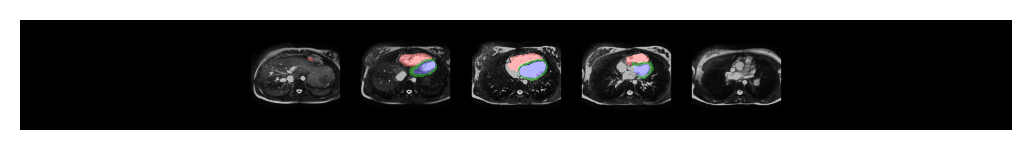

2020-11-20 09:08:32,795 INFO GT on AX


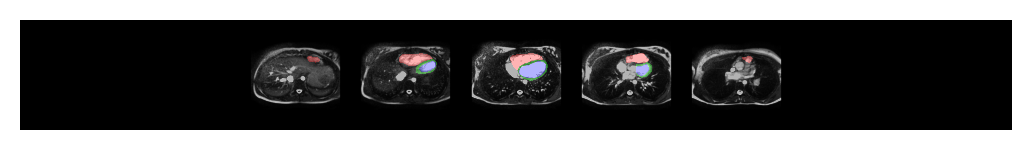

2020-11-20 09:08:33,159 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:08:33,221 INFO DICE LV: 0.9374600052833557
2020-11-20 09:08:33,282 INFO DICE RV: 0.8903728127479553
2020-11-20 09:08:33,345 INFO DICE MYO: 0.7364427447319031
2020-11-20 09:08:33,388 INFO m: [[ 0.7666 -0.519   0.3774 -0.9062]
 [ 0.2448  0.78    0.5757 -0.878 ]
 [-0.5938 -0.3489  0.725   5.66  ]]
2020-11-20 09:08:33,389 INFO m_mod: [[ 0.7666 -0.519   0.3774 -0.3892]
 [ 0.2448  0.78    0.5757 -0.5967]
 [-0.5938 -0.3489  0.725  -0.4736]]
2020-11-20 09:08:33,389 INFO m_scaled: [[ 0.7666 -0.519   0.3774 -0.7783]
 [ 0.2448  0.78    0.5757 -1.193 ]
 [-0.5938 -0.3489  0.725  -0.9473]]
2020-11-20 09:08:33,390 INFO 0000-11YU3CUF_2007-12-10_ES_msk.nrrd
2020-11-20 09:08:33,390 INFO Prediction on AX volume:
2020-11-20 09:08:33,932 INFO AX --> SAX rotated by the model
2020-11-20 09:08:33,933 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:08:33,955 INFO Target (AX2SAX):


(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:08:33,958 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:08:35,967 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:08:35,969 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:08:36,913 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe0fb723ea0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:08:37,443 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:08:37,542 INFO DICE LV: 0.8521862030029297
2020-11-20 09:08:37,608 INFO DICE RV: 0.780066728591919
2020-11-20 09

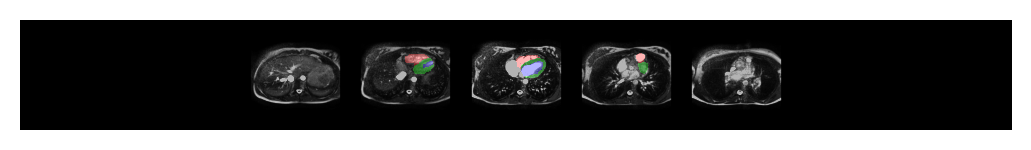

2020-11-20 09:08:38,457 INFO GT on AX


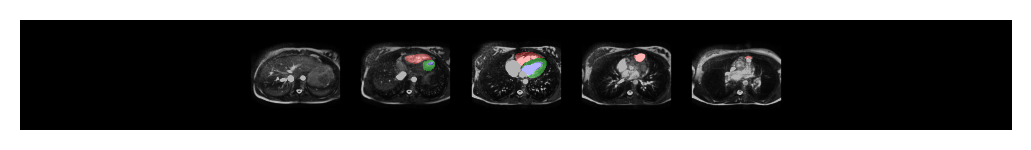

2020-11-20 09:08:38,819 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:08:38,880 INFO DICE LV: 0.8533313870429993
2020-11-20 09:08:38,942 INFO DICE RV: 0.773722231388092
2020-11-20 09:08:39,002 INFO DICE MYO: 0.7609823346138
2020-11-20 09:08:39,044 INFO m: [[ 0.7666 -0.5195  0.3772 -0.9062]
 [ 0.2451  0.78    0.576  -0.8784]
 [-0.5938 -0.3489  0.725   5.66  ]]
2020-11-20 09:08:39,045 INFO m_mod: [[ 0.7666 -0.5195  0.3772 -0.3896]
 [ 0.2451  0.78    0.576  -0.5967]
 [-0.5938 -0.3489  0.725  -0.4736]]
2020-11-20 09:08:39,045 INFO m_scaled: [[ 0.7666 -0.5195  0.3772 -0.7793]
 [ 0.2451  0.78    0.576  -1.193 ]
 [-0.5938 -0.3489  0.725  -0.9473]]
2020-11-20 09:08:39,046 INFO 0000-1E8MCV9L_2005-12-15_ED_msk.nrrd
2020-11-20 09:08:39,046 INFO Prediction on AX volume:
2020-11-20 09:08:39,588 INFO AX --> SAX rotated by the model
2020-11-20 09:08:39,589 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:08:39,606 INFO Target (AX2SAX):
2020

(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:08:39,608 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:08:41,568 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:08:41,570 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:08:42,492 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe0f883a730> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:08:43,021 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:08:43,132 INFO DICE LV: 0.8401699066162109
2020-11-20 09:08:43,203 INFO DICE RV: 0.7561699151992798
2020-11-20 0

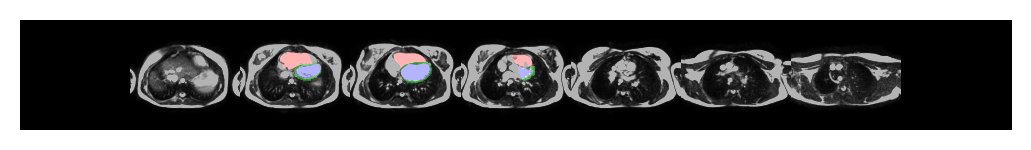

2020-11-20 09:08:44,072 INFO GT on AX


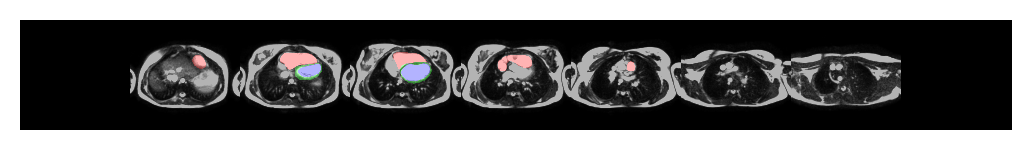

2020-11-20 09:08:44,436 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:08:44,508 INFO DICE LV: 0.8525602221488953
2020-11-20 09:08:44,579 INFO DICE RV: 0.7954720258712769
2020-11-20 09:08:44,651 INFO DICE MYO: 0.6699958443641663
2020-11-20 09:08:44,701 INFO m: [[ 0.689  -0.654   0.3127 -0.955 ]
 [ 0.2766  0.6357  0.7207 -0.9365]
 [-0.67   -0.41    0.6187  7.4   ]]
2020-11-20 09:08:44,702 INFO m_mod: [[ 0.689  -0.654   0.3127 -0.4756]
 [ 0.2766  0.6357  0.7207 -0.6953]
 [-0.67   -0.41    0.6187 -0.5684]]
2020-11-20 09:08:44,702 INFO m_scaled: [[ 0.689  -0.654   0.3127 -0.951 ]
 [ 0.2766  0.6357  0.7207 -1.391 ]
 [-0.67   -0.41    0.6187 -1.137 ]]
2020-11-20 09:08:44,703 INFO 0000-1E8MCV9L_2005-12-15_ES_msk.nrrd
2020-11-20 09:08:44,703 INFO Prediction on AX volume:
2020-11-20 09:08:45,269 INFO AX --> SAX rotated by the model
2020-11-20 09:08:45,271 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:08:45,316 INFO Target (AX2SAX):


(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:08:45,318 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:08:47,298 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:08:47,299 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:08:48,222 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe0f83da400> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:08:48,742 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:08:48,850 INFO DICE LV: 0.8469041585922241
2020-11-20 09:08:48,920 INFO DICE RV: 0.6312932968139648
2020-11-20 0

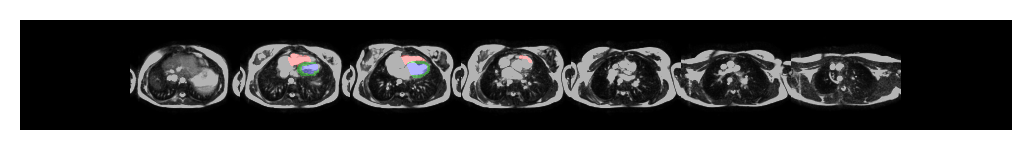

2020-11-20 09:08:49,780 INFO GT on AX


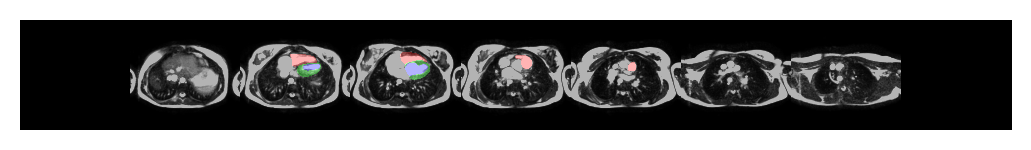

2020-11-20 09:08:50,144 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:08:50,215 INFO DICE LV: 0.8608227968215942
2020-11-20 09:08:50,286 INFO DICE RV: 0.6345022320747375
2020-11-20 09:08:50,356 INFO DICE MYO: 0.7192144393920898
2020-11-20 09:08:50,404 INFO m: [[ 0.6978 -0.6387  0.3237 -0.9507]
 [ 0.2732  0.6553  0.704  -0.931 ]
 [-0.662  -0.4028  0.632   7.184 ]]
2020-11-20 09:08:50,404 INFO m_mod: [[ 0.6978 -0.6387  0.3237 -0.4653]
 [ 0.2732  0.6553  0.704  -0.6846]
 [-0.662  -0.4028  0.632  -0.5576]]
2020-11-20 09:08:50,405 INFO m_scaled: [[ 0.6978 -0.6387  0.3237 -0.9307]
 [ 0.2732  0.6553  0.704  -1.369 ]
 [-0.662  -0.4028  0.632  -1.115 ]]
2020-11-20 09:08:50,406 INFO 0000-1PFT9CA1_2006-05-17_ED_msk.nrrd
2020-11-20 09:08:50,406 INFO Prediction on AX volume:
2020-11-20 09:08:50,998 INFO AX --> SAX rotated by the model
2020-11-20 09:08:51,000 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:08:51,041 INFO Target (AX2SAX):


(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:08:51,043 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:08:53,016 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:08:53,018 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:08:53,933 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe0f7822730> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:08:54,469 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:08:54,574 INFO DICE LV: 0.9254010915756226
2020-11-20 09:08:54,651 INFO DICE RV: 0.7706499099731445
2020-11-20 0

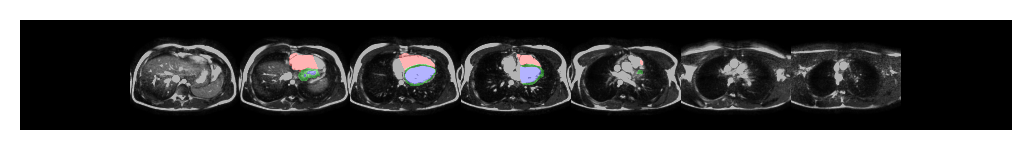

2020-11-20 09:08:55,531 INFO GT on AX


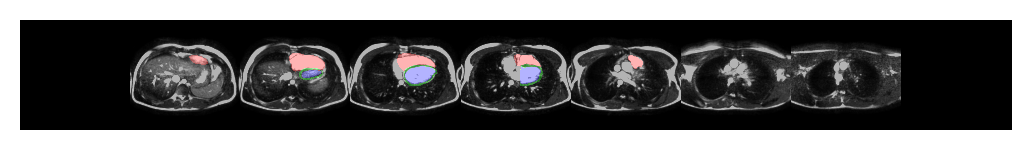

2020-11-20 09:08:55,908 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:08:55,984 INFO DICE LV: 0.9280369877815247
2020-11-20 09:08:56,056 INFO DICE RV: 0.7708406448364258
2020-11-20 09:08:56,126 INFO DICE MYO: 0.7002502083778381
2020-11-20 09:08:56,174 INFO m: [[ 0.7476 -0.5522  0.368  -0.9204]
 [ 0.2527  0.7495  0.6113 -0.895 ]
 [-0.614  -0.364   0.7     6.06  ]]
2020-11-20 09:08:56,175 INFO m_mod: [[ 0.7476 -0.5522  0.368  -0.4106]
 [ 0.2527  0.7495  0.6113 -0.6216]
 [-0.614  -0.364   0.7    -0.497 ]]
2020-11-20 09:08:56,175 INFO m_scaled: [[ 0.7476 -0.5522  0.368  -0.8213]
 [ 0.2527  0.7495  0.6113 -1.243 ]
 [-0.614  -0.364   0.7    -0.994 ]]
2020-11-20 09:08:56,176 INFO 0000-1PFT9CA1_2006-05-17_ES_msk.nrrd
2020-11-20 09:08:56,176 INFO Prediction on AX volume:
2020-11-20 09:08:56,765 INFO AX --> SAX rotated by the model
2020-11-20 09:08:56,766 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:08:56,784 INFO Target (AX2SAX):


(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:08:56,787 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:08:58,769 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:08:58,770 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:09:00,710 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe0f63777b8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:09:01,245 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:09:01,352 INFO DICE LV: 0.8274635076522827
2020-11-20 09:09:01,422 INFO DICE RV: 0.6567975282669067
2020-11-20 0

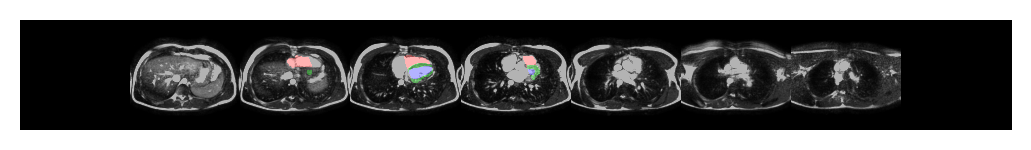

2020-11-20 09:09:02,290 INFO GT on AX


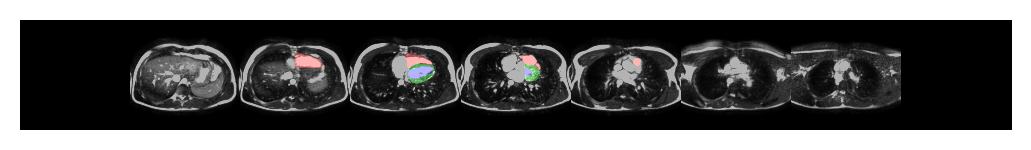

2020-11-20 09:09:02,663 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:09:02,736 INFO DICE LV: 0.8293524980545044
2020-11-20 09:09:02,807 INFO DICE RV: 0.6464184522628784
2020-11-20 09:09:02,878 INFO DICE MYO: 0.6567400693893433
2020-11-20 09:09:02,926 INFO m: [[ 0.7427 -0.5615  0.3655 -0.924 ]
 [ 0.2551  0.741   0.621  -0.899 ]
 [-0.6196 -0.368   0.6934  6.164 ]]
2020-11-20 09:09:02,927 INFO m_mod: [[ 0.7427 -0.5615  0.3655 -0.416 ]
 [ 0.2551  0.741   0.621  -0.628 ]
 [-0.6196 -0.368   0.6934 -0.503 ]]
2020-11-20 09:09:02,927 INFO m_scaled: [[ 0.7427 -0.5615  0.3655 -0.832 ]
 [ 0.2551  0.741   0.621  -1.256 ]
 [-0.6196 -0.368   0.6934 -1.006 ]]
2020-11-20 09:09:02,928 INFO 0000-2V8HJLHN_2005-08-30_ED_msk.nrrd
2020-11-20 09:09:02,928 INFO Prediction on AX volume:
2020-11-20 09:09:03,500 INFO AX --> SAX rotated by the model
2020-11-20 09:09:03,500 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:09:03,518 INFO Target (AX2SAX):


(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:09:03,521 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:09:06,537 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:09:06,539 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:09:07,472 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe0f500c8c8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:09:08,011 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:09:08,115 INFO DICE LV: 0.9240158796310425
2020-11-20 09:09:08,192 INFO DICE RV: 0.7894015312194824
2020-11-20 0

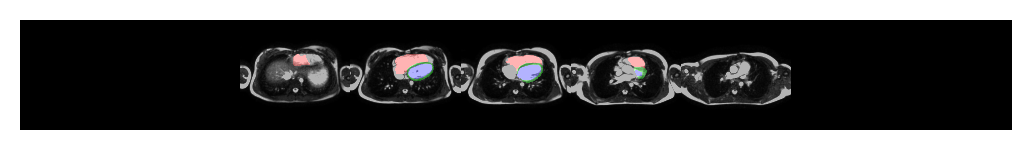

2020-11-20 09:09:09,060 INFO GT on AX


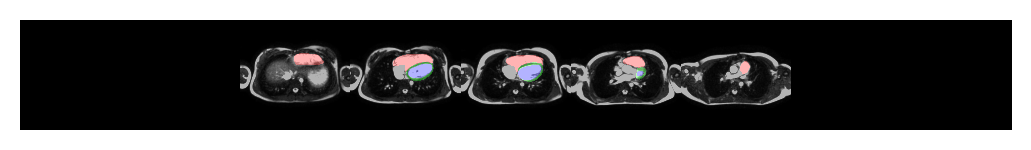

2020-11-20 09:09:09,424 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:09:09,499 INFO DICE LV: 0.9252261519432068
2020-11-20 09:09:09,569 INFO DICE RV: 0.7891726493835449
2020-11-20 09:09:09,640 INFO DICE MYO: 0.6998375654220581
2020-11-20 09:09:09,687 INFO m: [[ 0.786  -0.486   0.383  -0.889 ]
 [ 0.2367  0.8076  0.54   -0.859 ]
 [-0.572  -0.3337  0.75    5.26  ]]
2020-11-20 09:09:09,688 INFO m_mod: [[ 0.786  -0.486   0.383  -0.3677]
 [ 0.2367  0.8076  0.54   -0.5693]
 [-0.572  -0.3337  0.75   -0.4492]]
2020-11-20 09:09:09,688 INFO m_scaled: [[ 0.786  -0.486   0.383  -0.7354]
 [ 0.2367  0.8076  0.54   -1.139 ]
 [-0.572  -0.3337  0.75   -0.8984]]
2020-11-20 09:09:09,689 INFO 0000-2V8HJLHN_2005-08-30_ES_msk.nrrd
2020-11-20 09:09:09,689 INFO Prediction on AX volume:
2020-11-20 09:09:10,262 INFO AX --> SAX rotated by the model
2020-11-20 09:09:10,263 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:09:10,281 INFO Target (AX2SAX):


(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:09:10,283 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:09:12,294 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:09:12,296 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:09:13,242 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe0f428fea0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:09:13,781 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:09:13,886 INFO DICE LV: 0.8348851203918457
2020-11-20 09:09:13,963 INFO DICE RV: 0.6621594429016113
2020-11-20 0

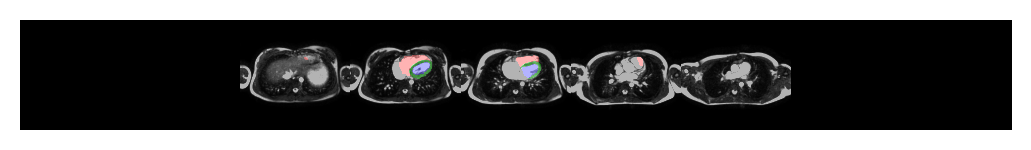

2020-11-20 09:09:14,833 INFO GT on AX


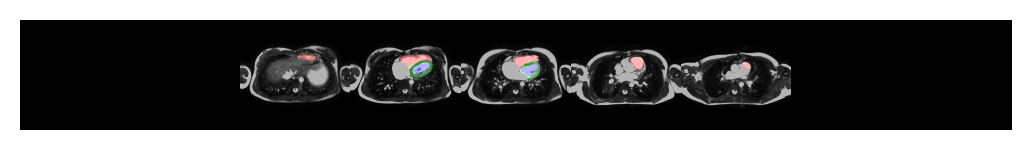

2020-11-20 09:09:15,209 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:09:15,294 INFO DICE LV: 0.8386207222938538
2020-11-20 09:09:15,373 INFO DICE RV: 0.6617440581321716
2020-11-20 09:09:15,452 INFO DICE MYO: 0.7034295797348022
2020-11-20 09:09:15,502 INFO m: [[ 0.793  -0.4717  0.3845 -0.882 ]
 [ 0.2325  0.819   0.525  -0.85  ]
 [-0.5625 -0.327   0.7593  5.105 ]]
2020-11-20 09:09:15,503 INFO m_mod: [[ 0.793  -0.4717  0.3845 -0.359 ]
 [ 0.2325  0.819   0.525  -0.5586]
 [-0.5625 -0.327   0.7593 -0.4395]]
2020-11-20 09:09:15,503 INFO m_scaled: [[ 0.793  -0.4717  0.3845 -0.718 ]
 [ 0.2325  0.819   0.525  -1.117 ]
 [-0.5625 -0.327   0.7593 -0.879 ]]
2020-11-20 09:09:15,504 INFO 0000-2WHFP73X_2007-03-28_ED_msk.nrrd
2020-11-20 09:09:15,504 INFO Prediction on AX volume:
2020-11-20 09:09:16,113 INFO AX --> SAX rotated by the model
2020-11-20 09:09:16,114 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:09:16,132 INFO Target (AX2SAX):


(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:09:16,134 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:09:18,235 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:09:18,237 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:09:19,204 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe0ce674f28> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:09:19,742 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:09:19,846 INFO DICE LV: 0.8788191080093384
2020-11-20 09:09:19,918 INFO DICE RV: 0.792796790599823
2020-11-20 09

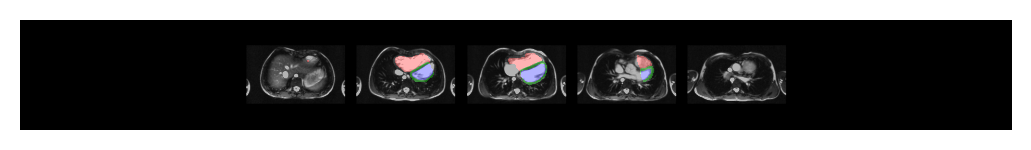

2020-11-20 09:09:20,803 INFO GT on AX


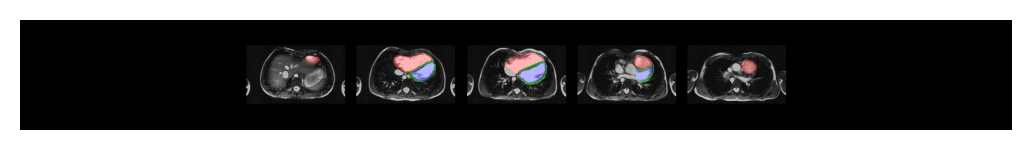

2020-11-20 09:09:21,170 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:09:21,241 INFO DICE LV: 0.8774800896644592
2020-11-20 09:09:21,313 INFO DICE RV: 0.7926454544067383
2020-11-20 09:09:21,385 INFO DICE MYO: 0.7032718062400818
2020-11-20 09:09:21,434 INFO m: [[ 0.7744 -0.5063  0.3796 -0.8994]
 [ 0.2418  0.791   0.562  -0.87  ]
 [-0.585  -0.3433  0.7344  5.492 ]]
2020-11-20 09:09:21,434 INFO m_mod: [[ 0.7744 -0.5063  0.3796 -0.3804]
 [ 0.2418  0.791   0.562  -0.586 ]
 [-0.585  -0.3433  0.7344 -0.4639]]
2020-11-20 09:09:21,435 INFO m_scaled: [[ 0.7744 -0.5063  0.3796 -0.7607]
 [ 0.2418  0.791   0.562  -1.172 ]
 [-0.585  -0.3433  0.7344 -0.9277]]
2020-11-20 09:09:21,436 INFO 0000-2WHFP73X_2007-03-28_ES_msk.nrrd
2020-11-20 09:09:21,436 INFO Prediction on AX volume:
2020-11-20 09:09:22,021 INFO AX --> SAX rotated by the model
2020-11-20 09:09:22,022 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:09:22,042 INFO Target (AX2SAX):


(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:09:22,044 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:09:24,033 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:09:24,035 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:09:24,982 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe0cdad3ae8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:09:25,514 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:09:25,620 INFO DICE LV: 0.7894673943519592
2020-11-20 09:09:25,698 INFO DICE RV: 0.6206170916557312
2020-11-20 0

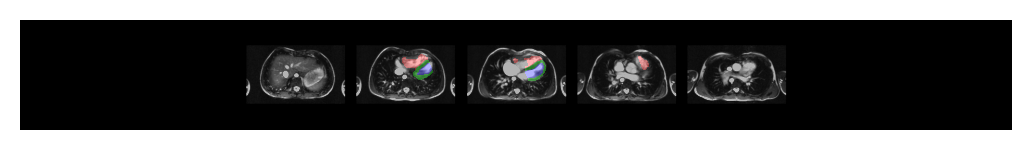

2020-11-20 09:09:26,561 INFO GT on AX


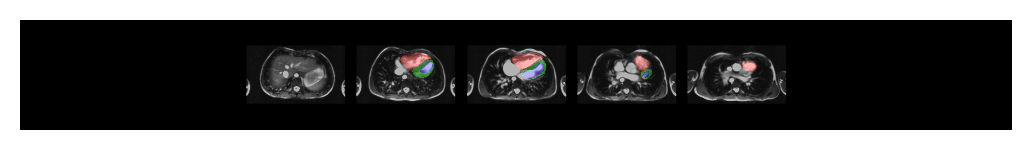

2020-11-20 09:09:26,931 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:09:27,007 INFO DICE LV: 0.7861775755882263
2020-11-20 09:09:27,078 INFO DICE RV: 0.6143680214881897
2020-11-20 09:09:27,149 INFO DICE MYO: 0.6877307295799255
2020-11-20 09:09:27,199 INFO m: [[ 0.783  -0.4905  0.3828 -0.8916]
 [ 0.2375  0.8047  0.545  -0.8613]
 [-0.5747 -0.3357  0.7466  5.31  ]]
2020-11-20 09:09:27,199 INFO m_mod: [[ 0.783  -0.4905  0.3828 -0.37  ]
 [ 0.2375  0.8047  0.545  -0.5728]
 [-0.5747 -0.3357  0.7466 -0.4521]]
2020-11-20 09:09:27,200 INFO m_scaled: [[ 0.783  -0.4905  0.3828 -0.74  ]
 [ 0.2375  0.8047  0.545  -1.1455]
 [-0.5747 -0.3357  0.7466 -0.9043]]
2020-11-20 09:09:27,201 INFO 0000-44U3AGET_2006-08-01_ED_msk.nrrd
2020-11-20 09:09:27,201 INFO Prediction on AX volume:
2020-11-20 09:09:27,755 INFO AX --> SAX rotated by the model
2020-11-20 09:09:27,756 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:09:27,783 INFO Target (AX2SAX):


(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:09:27,785 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:09:29,784 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:09:29,786 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:09:30,732 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe0cceb2ae8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:09:31,272 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:09:31,376 INFO DICE LV: 0.8545107245445251
2020-11-20 09:09:31,448 INFO DICE RV: 0.6990565657615662
2020-11-20 0

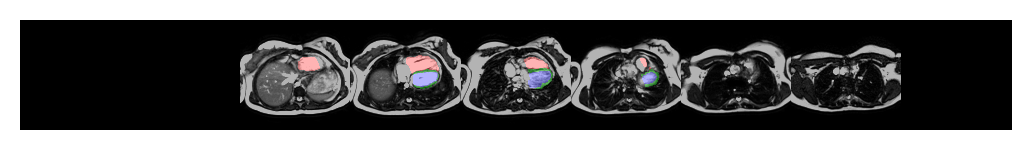

2020-11-20 09:09:32,317 INFO GT on AX


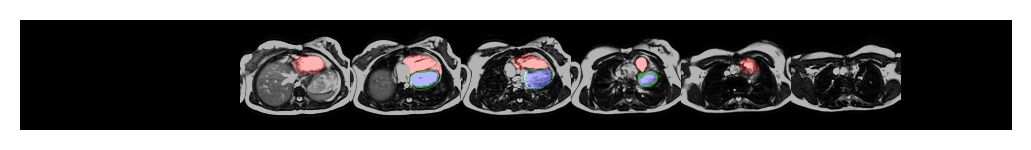

2020-11-20 09:09:32,681 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:09:32,752 INFO DICE LV: 0.873817503452301
2020-11-20 09:09:32,823 INFO DICE RV: 0.7004063725471497
2020-11-20 09:09:32,893 INFO DICE MYO: 0.5722908973693848
2020-11-20 09:09:32,941 INFO m: [[ 0.7    -0.6343  0.328  -0.9497]
 [ 0.272   0.6616  0.6987 -0.9297]
 [-0.66   -0.4001  0.6353  7.137 ]]
2020-11-20 09:09:32,941 INFO m_mod: [[ 0.7    -0.6343  0.328  -0.4639]
 [ 0.272   0.6616  0.6987 -0.6816]
 [-0.66   -0.4001  0.6353 -0.555 ]]
2020-11-20 09:09:32,942 INFO m_scaled: [[ 0.7    -0.6343  0.328  -0.9277]
 [ 0.272   0.6616  0.6987 -1.363 ]
 [-0.66   -0.4001  0.6353 -1.11  ]]
2020-11-20 09:09:32,943 INFO 0000-44U3AGET_2006-08-01_ES_msk.nrrd
2020-11-20 09:09:32,943 INFO Prediction on AX volume:
2020-11-20 09:09:33,522 INFO AX --> SAX rotated by the model
2020-11-20 09:09:33,524 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:09:33,566 INFO Target (AX2SAX):
2

(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:09:33,568 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:09:35,542 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:09:35,544 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:09:36,479 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe0c78d8b70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:09:37,013 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:09:37,120 INFO DICE LV: 0.8171917200088501
2020-11-20 09:09:37,193 INFO DICE RV: 0.6214804649353027
2020-11-20 0

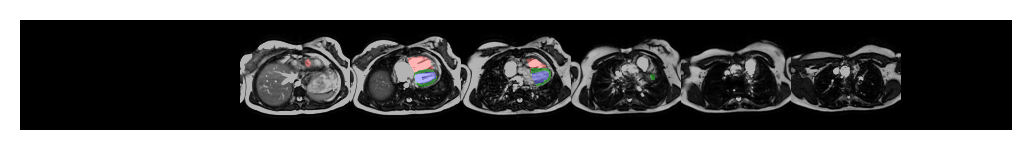

2020-11-20 09:09:38,077 INFO GT on AX


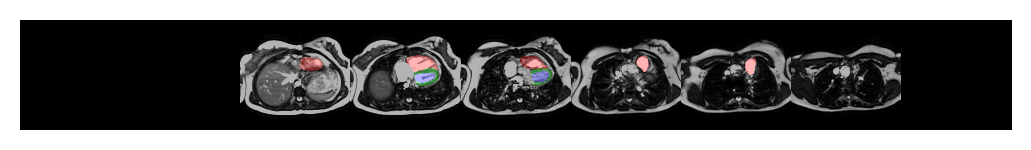

2020-11-20 09:09:38,453 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:09:38,531 INFO DICE LV: 0.8336633443832397
2020-11-20 09:09:38,604 INFO DICE RV: 0.617002546787262
2020-11-20 09:09:38,675 INFO DICE MYO: 0.6049903631210327
2020-11-20 09:09:38,724 INFO m: [[ 0.7314 -0.581   0.357  -0.9316]
 [ 0.2598  0.7217  0.642  -0.908 ]
 [-0.6304 -0.3767  0.6787  6.418 ]]
2020-11-20 09:09:38,724 INFO m_mod: [[ 0.7314 -0.581   0.357  -0.4287]
 [ 0.2598  0.7217  0.642  -0.6426]
 [-0.6304 -0.3767  0.6787 -0.517 ]]
2020-11-20 09:09:38,725 INFO m_scaled: [[ 0.7314 -0.581   0.357  -0.8574]
 [ 0.2598  0.7217  0.642  -1.285 ]
 [-0.6304 -0.3767  0.6787 -1.034 ]]
2020-11-20 09:09:38,727 INFO 0000-49RHVC6C_2005-11-22_ED_msk.nrrd
2020-11-20 09:09:38,727 INFO Prediction on AX volume:
2020-11-20 09:09:39,332 INFO AX --> SAX rotated by the model
2020-11-20 09:09:39,334 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:09:39,365 INFO Target (AX2SAX):
2

(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:09:39,367 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:09:41,364 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:09:41,366 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:09:42,298 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe0c5c32730> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:09:42,829 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:09:42,933 INFO DICE LV: 0.9168039560317993
2020-11-20 09:09:43,004 INFO DICE RV: 0.7538872361183167
2020-11-20 0

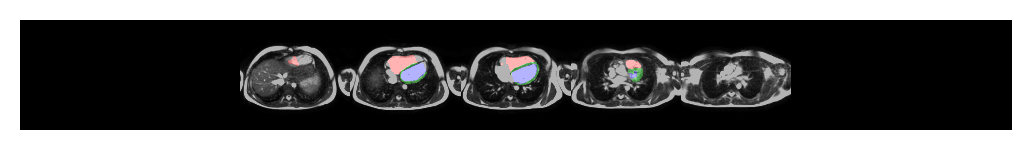

2020-11-20 09:09:43,868 INFO GT on AX


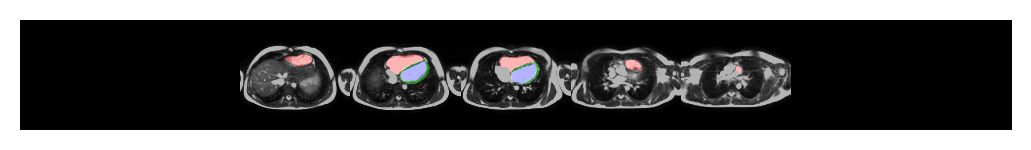

2020-11-20 09:09:44,229 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:09:44,295 INFO DICE LV: 0.9205717444419861
2020-11-20 09:09:44,363 INFO DICE RV: 0.7609010338783264
2020-11-20 09:09:44,430 INFO DICE MYO: 0.6638720035552979
2020-11-20 09:09:44,477 INFO m: [[ 0.7163 -0.608   0.3425 -0.9404]
 [ 0.266   0.692   0.6714 -0.919 ]
 [-0.6445 -0.3896  0.657   6.746 ]]
2020-11-20 09:09:44,478 INFO m_mod: [[ 0.7163 -0.608   0.3425 -0.4448]
 [ 0.266   0.692   0.6714 -0.661 ]
 [-0.6445 -0.3896  0.657  -0.535 ]]
2020-11-20 09:09:44,478 INFO m_scaled: [[ 0.7163 -0.608   0.3425 -0.8896]
 [ 0.266   0.692   0.6714 -1.322 ]
 [-0.6445 -0.3896  0.657  -1.07  ]]
2020-11-20 09:09:44,479 INFO 0000-49RHVC6C_2005-11-22_ES_msk.nrrd
2020-11-20 09:09:44,479 INFO Prediction on AX volume:
2020-11-20 09:09:45,035 INFO AX --> SAX rotated by the model
2020-11-20 09:09:45,037 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:09:45,081 INFO Target (AX2SAX):


(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:09:45,083 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:09:47,060 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:09:47,062 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:09:47,981 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe0b66d17b8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:09:48,519 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:09:48,629 INFO DICE LV: 0.7714383602142334
2020-11-20 09:09:48,708 INFO DICE RV: 0.6652843356132507
2020-11-20 0

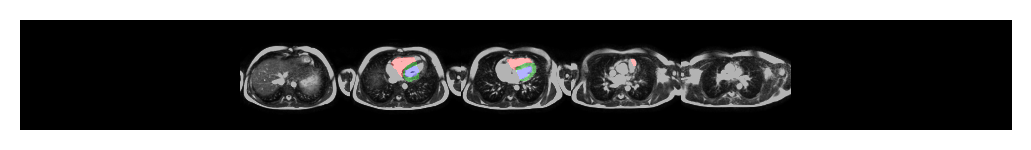

2020-11-20 09:09:49,593 INFO GT on AX


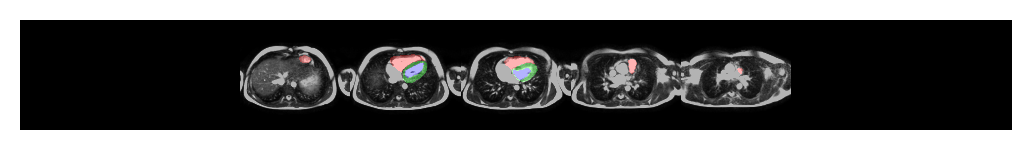

2020-11-20 09:09:49,967 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:09:50,036 INFO DICE LV: 0.8147741556167603
2020-11-20 09:09:50,105 INFO DICE RV: 0.6816104650497437
2020-11-20 09:09:50,176 INFO DICE MYO: 0.6822425127029419
2020-11-20 09:09:50,225 INFO m: [[ 0.719  -0.6025  0.3455 -0.939 ]
 [ 0.2651  0.698   0.6655 -0.917 ]
 [-0.642  -0.387   0.6616  6.68  ]]
2020-11-20 09:09:50,226 INFO m_mod: [[ 0.719  -0.6025  0.3455 -0.4414]
 [ 0.2651  0.698   0.6655 -0.6577]
 [-0.642  -0.387   0.6616 -0.5312]]
2020-11-20 09:09:50,226 INFO m_scaled: [[ 0.719  -0.6025  0.3455 -0.883 ]
 [ 0.2651  0.698   0.6655 -1.315 ]
 [-0.642  -0.387   0.6616 -1.0625]]
2020-11-20 09:09:50,228 INFO 0000-76RJ3Z26_2006-11-23_ED_msk.nrrd
2020-11-20 09:09:50,229 INFO Prediction on AX volume:
2020-11-20 09:09:50,805 INFO AX --> SAX rotated by the model
2020-11-20 09:09:50,806 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:09:50,834 INFO Target (AX2SAX):


(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:09:50,837 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:09:52,833 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:09:52,835 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:09:53,779 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe0b51f4840> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:09:54,318 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:09:54,428 INFO DICE LV: 0.7628140449523926
2020-11-20 09:09:54,499 INFO DICE RV: 0.6820454001426697
2020-11-20 0

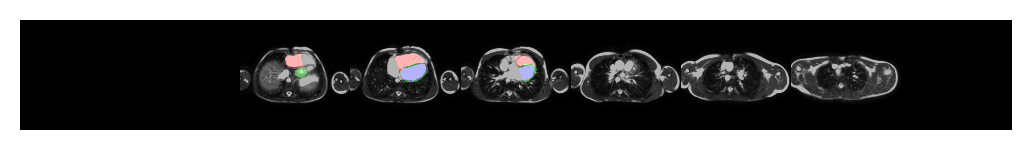

2020-11-20 09:09:55,365 INFO GT on AX


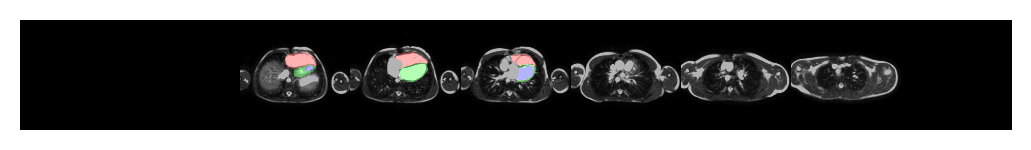

2020-11-20 09:09:55,736 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:09:55,804 INFO DICE LV: 0.7617344856262207
2020-11-20 09:09:55,870 INFO DICE RV: 0.6884173154830933
2020-11-20 09:09:55,936 INFO DICE MYO: 0.5159362554550171
2020-11-20 09:09:55,984 INFO m: [[ 0.7705 -0.5127  0.3787 -0.9023]
 [ 0.2433  0.786   0.5684 -0.874 ]
 [-0.589  -0.346   0.7305  5.566 ]]
2020-11-20 09:09:55,984 INFO m_mod: [[ 0.7705 -0.5127  0.3787 -0.3843]
 [ 0.2433  0.786   0.5684 -0.59  ]
 [-0.589  -0.346   0.7305 -0.4683]]
2020-11-20 09:09:55,985 INFO m_scaled: [[ 0.7705 -0.5127  0.3787 -0.7686]
 [ 0.2433  0.786   0.5684 -1.18  ]
 [-0.589  -0.346   0.7305 -0.9365]]
2020-11-20 09:09:55,985 INFO 0000-76RJ3Z26_2006-11-23_ES_msk.nrrd
2020-11-20 09:09:55,986 INFO Prediction on AX volume:
2020-11-20 09:09:58,612 INFO AX --> SAX rotated by the model
2020-11-20 09:09:58,613 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:09:58,637 INFO Target (AX2SAX):


(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:09:58,639 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:10:00,725 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:10:00,726 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:10:01,764 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe0c78f68c8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:10:02,314 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:10:02,421 INFO DICE LV: 0.8525184988975525
2020-11-20 09:10:02,491 INFO DICE RV: 0.6008117198944092
2020-11-20 0

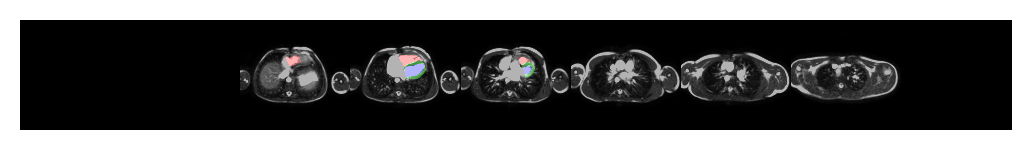

2020-11-20 09:10:03,348 INFO GT on AX


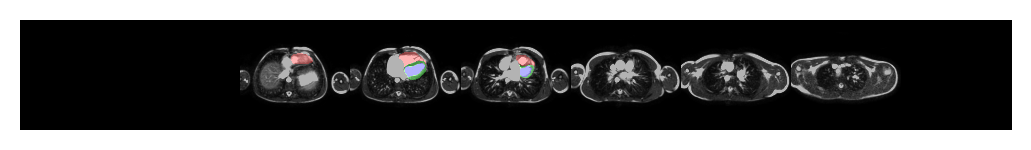

2020-11-20 09:10:03,727 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:10:03,791 INFO DICE LV: 0.851956844329834
2020-11-20 09:10:03,857 INFO DICE RV: 0.603212296962738
2020-11-20 09:10:03,922 INFO DICE MYO: 0.6581470966339111
2020-11-20 09:10:03,964 INFO m: [[ 0.773  -0.5093  0.3794 -0.901 ]
 [ 0.2427  0.7886  0.5654 -0.872 ]
 [-0.587  -0.345   0.733   5.53  ]]
2020-11-20 09:10:03,965 INFO m_mod: [[ 0.773  -0.5093  0.3794 -0.3823]
 [ 0.2427  0.7886  0.5654 -0.588 ]
 [-0.587  -0.345   0.733  -0.4658]]
2020-11-20 09:10:03,965 INFO m_scaled: [[ 0.773  -0.5093  0.3794 -0.7646]
 [ 0.2427  0.7886  0.5654 -1.176 ]
 [-0.587  -0.345   0.733  -0.9316]]
2020-11-20 09:10:03,966 INFO 0000-8J5NZ5G7_2008-03-27_ED_msk.nrrd
2020-11-20 09:10:03,967 INFO Prediction on AX volume:
2020-11-20 09:10:04,546 INFO AX --> SAX rotated by the model
2020-11-20 09:10:04,546 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:10:04,567 INFO Target (AX2SAX):
20

(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:10:04,569 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:10:07,645 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:10:07,646 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:10:08,610 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe0f67b98c8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:10:09,142 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:10:09,241 INFO DICE LV: 0.8871408700942993
2020-11-20 09:10:09,307 INFO DICE RV: 0.8078519105911255
2020-11-20 0

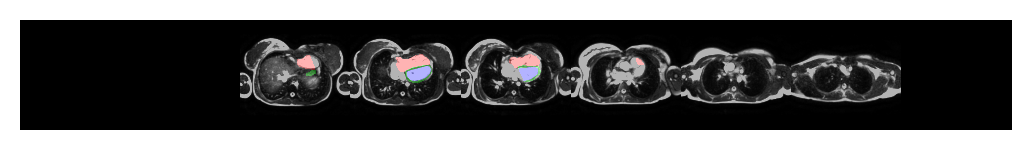

2020-11-20 09:10:10,147 INFO GT on AX


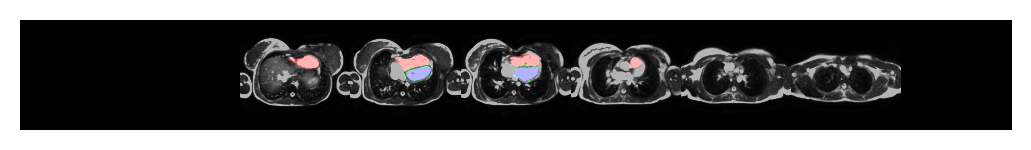

2020-11-20 09:10:10,514 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:10:10,579 INFO DICE LV: 0.8855993747711182
2020-11-20 09:10:10,643 INFO DICE RV: 0.8119204044342041
2020-11-20 09:10:10,708 INFO DICE MYO: 0.6248413920402527
2020-11-20 09:10:10,752 INFO m: [[ 0.73   -0.5845  0.3547 -0.9326]
 [ 0.261   0.718   0.646  -0.909 ]
 [-0.632  -0.3787  0.6763  6.45  ]]
2020-11-20 09:10:10,752 INFO m_mod: [[ 0.73   -0.5845  0.3547 -0.4302]
 [ 0.261   0.718   0.646  -0.6445]
 [-0.632  -0.3787  0.6763 -0.5186]]
2020-11-20 09:10:10,753 INFO m_scaled: [[ 0.73   -0.5845  0.3547 -0.8604]
 [ 0.261   0.718   0.646  -1.289 ]
 [-0.632  -0.3787  0.6763 -1.037 ]]
2020-11-20 09:10:10,753 INFO 0000-8J5NZ5G7_2008-03-27_ES_msk.nrrd
2020-11-20 09:10:10,754 INFO Prediction on AX volume:
2020-11-20 09:10:11,338 INFO AX --> SAX rotated by the model
2020-11-20 09:10:11,338 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:10:11,356 INFO Target (AX2SAX):


(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:10:11,358 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:10:13,350 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:10:13,352 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:10:14,278 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe120695510> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:10:14,804 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:10:14,904 INFO DICE LV: 0.8745595216751099
2020-11-20 09:10:14,969 INFO DICE RV: 0.7641084790229797
2020-11-20 0

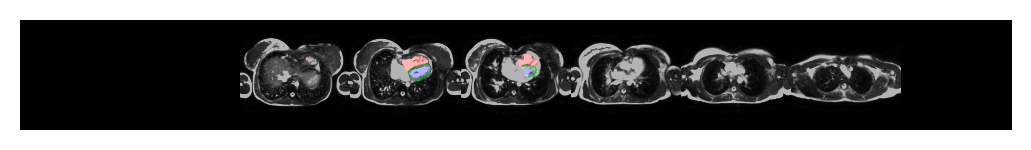

2020-11-20 09:10:15,814 INFO GT on AX


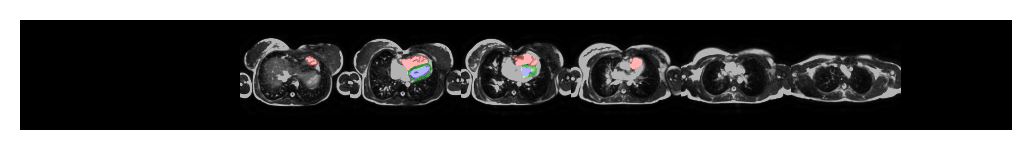

2020-11-20 09:10:16,185 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:10:16,252 INFO DICE LV: 0.8739097118377686
2020-11-20 09:10:16,318 INFO DICE RV: 0.7593104839324951
2020-11-20 09:10:16,383 INFO DICE MYO: 0.7237391471862793
2020-11-20 09:10:16,425 INFO m: [[ 0.7314 -0.5806  0.3567 -0.931 ]
 [ 0.2598  0.7217  0.6416 -0.9077]
 [-0.63   -0.3767  0.6787  6.4   ]]
2020-11-20 09:10:16,426 INFO m_mod: [[ 0.7314 -0.5806  0.3567 -0.4277]
 [ 0.2598  0.7217  0.6416 -0.6416]
 [-0.63   -0.3767  0.6787 -0.516 ]]
2020-11-20 09:10:16,427 INFO m_scaled: [[ 0.7314 -0.5806  0.3567 -0.8555]
 [ 0.2598  0.7217  0.6416 -1.283 ]
 [-0.63   -0.3767  0.6787 -1.032 ]]
2020-11-20 09:10:16,427 INFO 0000-9A8UTCZ4_2007-03-16_ED_msk.nrrd
2020-11-20 09:10:16,427 INFO Prediction on AX volume:
2020-11-20 09:10:17,009 INFO AX --> SAX rotated by the model
2020-11-20 09:10:17,010 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:10:17,048 INFO Target (AX2SAX):


(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:10:17,051 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:10:19,028 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:10:19,030 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:10:19,948 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe0f84b7b70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:10:20,473 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:10:20,573 INFO DICE LV: 0.9174551367759705
2020-11-20 09:10:20,638 INFO DICE RV: 0.8276097178459167
2020-11-20 0

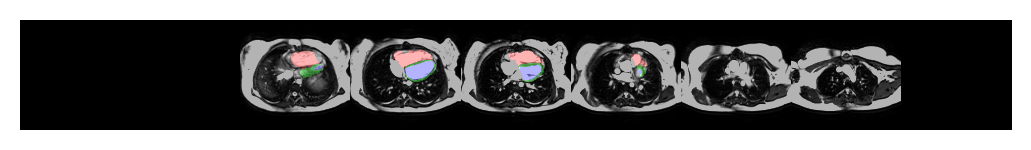

2020-11-20 09:10:21,486 INFO GT on AX


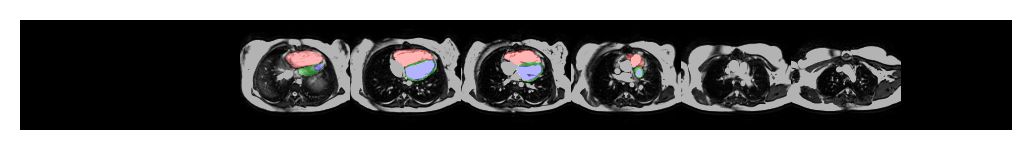

2020-11-20 09:10:21,852 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:10:21,919 INFO DICE LV: 0.9167642593383789
2020-11-20 09:10:21,984 INFO DICE RV: 0.8307916522026062
2020-11-20 09:10:22,048 INFO DICE MYO: 0.6674066781997681
2020-11-20 09:10:22,090 INFO m: [[ 0.678  -0.672   0.2993 -0.96  ]
 [ 0.2805  0.613   0.7393 -0.943 ]
 [-0.6797 -0.4175  0.604   7.684 ]]
2020-11-20 09:10:22,091 INFO m_mod: [[ 0.678  -0.672   0.2993 -0.4883]
 [ 0.2805  0.613   0.7393 -0.709 ]
 [-0.6797 -0.4175  0.604  -0.582 ]]
2020-11-20 09:10:22,091 INFO m_scaled: [[ 0.678  -0.672   0.2993 -0.9766]
 [ 0.2805  0.613   0.7393 -1.418 ]
 [-0.6797 -0.4175  0.604  -1.164 ]]
2020-11-20 09:10:22,092 INFO 0000-9A8UTCZ4_2007-03-16_ES_msk.nrrd
2020-11-20 09:10:22,092 INFO Prediction on AX volume:
2020-11-20 09:10:22,635 INFO AX --> SAX rotated by the model
2020-11-20 09:10:22,636 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:10:22,658 INFO Target (AX2SAX):


(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:10:22,660 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:10:24,636 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:10:24,638 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:10:25,558 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe0f4184378> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:10:26,080 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:10:26,179 INFO DICE LV: 0.857566773891449
2020-11-20 09:10:26,245 INFO DICE RV: 0.6723920702934265
2020-11-20 09

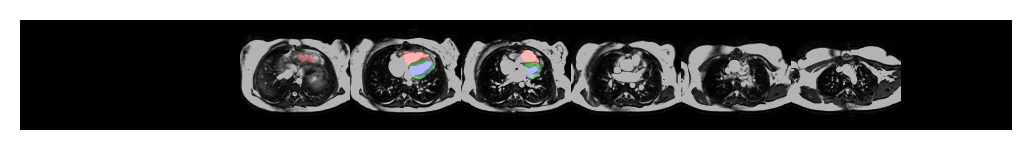

2020-11-20 09:10:27,085 INFO GT on AX


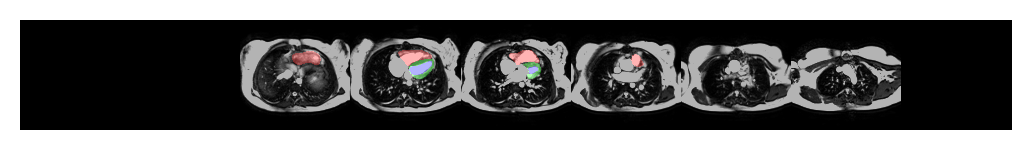

2020-11-20 09:10:27,450 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:10:27,514 INFO DICE LV: 0.8548247218132019
2020-11-20 09:10:27,579 INFO DICE RV: 0.6741364598274231
2020-11-20 09:10:27,644 INFO DICE MYO: 0.717515230178833
2020-11-20 09:10:27,686 INFO m: [[ 0.688  -0.655   0.3127 -0.9556]
 [ 0.2766  0.635   0.7207 -0.937 ]
 [-0.671  -0.4097  0.618   7.426 ]]
2020-11-20 09:10:27,686 INFO m_mod: [[ 0.688  -0.655   0.3127 -0.477 ]
 [ 0.2766  0.635   0.7207 -0.6963]
 [-0.671  -0.4097  0.618  -0.5693]]
2020-11-20 09:10:27,687 INFO m_scaled: [[ 0.688  -0.655   0.3127 -0.954 ]
 [ 0.2766  0.635   0.7207 -1.393 ]
 [-0.671  -0.4097  0.618  -1.139 ]]
2020-11-20 09:10:27,687 INFO 0000-9MTQG5XR_2005-05-23_ED_msk.nrrd
2020-11-20 09:10:27,688 INFO Prediction on AX volume:
2020-11-20 09:10:28,270 INFO AX --> SAX rotated by the model
2020-11-20 09:10:28,271 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:10:28,292 INFO Target (AX2SAX):
2

(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:10:28,294 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:10:30,283 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:10:30,285 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:10:31,210 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe0c7df9400> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:10:31,740 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:10:31,840 INFO DICE LV: 0.9047075510025024
2020-11-20 09:10:31,907 INFO DICE RV: 0.8262073397636414
2020-11-20 0

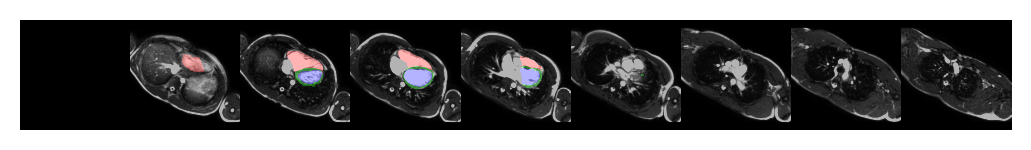

2020-11-20 09:10:32,764 INFO GT on AX


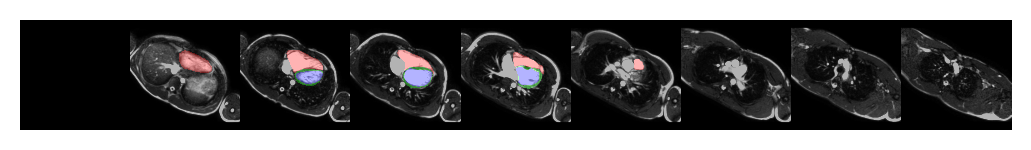

2020-11-20 09:10:33,138 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:10:33,202 INFO DICE LV: 0.9053797125816345
2020-11-20 09:10:33,266 INFO DICE RV: 0.8284197449684143
2020-11-20 09:10:33,330 INFO DICE MYO: 0.6765316724777222
2020-11-20 09:10:33,376 INFO m: [[ 0.7593 -0.533   0.3733 -0.912 ]
 [ 0.2484  0.7676  0.5903 -0.885 ]
 [-0.6016 -0.3555  0.7153  5.812 ]]
2020-11-20 09:10:33,376 INFO m_mod: [[ 0.7593 -0.533   0.3733 -0.3975]
 [ 0.2484  0.7676  0.5903 -0.6064]
 [-0.6016 -0.3555  0.7153 -0.483 ]]
2020-11-20 09:10:33,377 INFO m_scaled: [[ 0.7593 -0.533   0.3733 -0.795 ]
 [ 0.2484  0.7676  0.5903 -1.213 ]
 [-0.6016 -0.3555  0.7153 -0.966 ]]
2020-11-20 09:10:33,377 INFO 0000-9MTQG5XR_2005-05-23_ES_msk.nrrd
2020-11-20 09:10:33,378 INFO Prediction on AX volume:
2020-11-20 09:10:33,952 INFO AX --> SAX rotated by the model
2020-11-20 09:10:33,953 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:10:33,978 INFO Target (AX2SAX):


(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:10:33,981 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:10:35,957 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:10:35,958 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:10:36,894 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe0fbd20488> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:10:37,422 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:10:37,522 INFO DICE LV: 0.8698891401290894
2020-11-20 09:10:37,586 INFO DICE RV: 0.769256055355072
2020-11-20 09

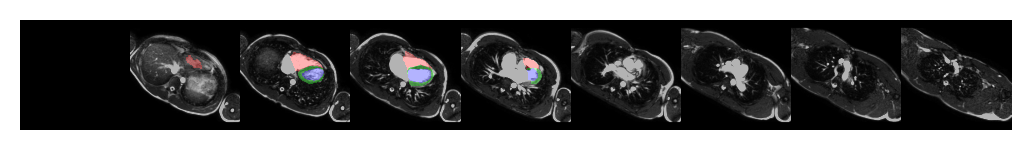

2020-11-20 09:10:38,442 INFO GT on AX


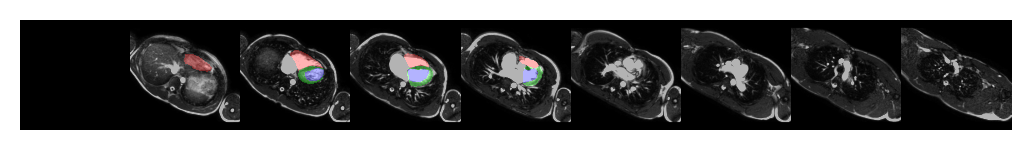

2020-11-20 09:10:38,820 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:10:38,887 INFO DICE LV: 0.8716173768043518
2020-11-20 09:10:38,954 INFO DICE RV: 0.772666871547699
2020-11-20 09:10:39,021 INFO DICE MYO: 0.7423303127288818
2020-11-20 09:10:39,064 INFO m: [[ 0.76   -0.5317  0.3735 -0.9116]
 [ 0.2484  0.769   0.5894 -0.8843]
 [-0.6006 -0.355   0.7163  5.8   ]]
2020-11-20 09:10:39,064 INFO m_mod: [[ 0.76   -0.5317  0.3735 -0.3965]
 [ 0.2484  0.769   0.5894 -0.6055]
 [-0.6006 -0.355   0.7163 -0.482 ]]
2020-11-20 09:10:39,065 INFO m_scaled: [[ 0.76   -0.5317  0.3735 -0.793 ]
 [ 0.2484  0.769   0.5894 -1.211 ]
 [-0.6006 -0.355   0.7163 -0.964 ]]
2020-11-20 09:10:39,066 INFO 0000-CKFQTQ9F_2006-11-10_ED_msk.nrrd
2020-11-20 09:10:39,066 INFO Prediction on AX volume:
2020-11-20 09:10:39,616 INFO AX --> SAX rotated by the model
2020-11-20 09:10:39,617 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:10:39,652 INFO Target (AX2SAX):
2

(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:10:39,655 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:10:41,679 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:10:41,681 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:10:42,605 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe0c7f9eea0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:10:43,132 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:10:43,243 INFO DICE LV: 0.9272708296775818
2020-11-20 09:10:43,315 INFO DICE RV: 0.816006600856781
2020-11-20 09

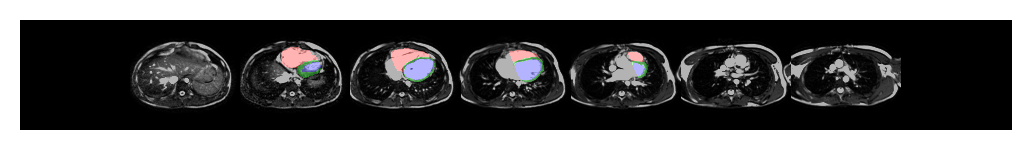

2020-11-20 09:10:44,191 INFO GT on AX


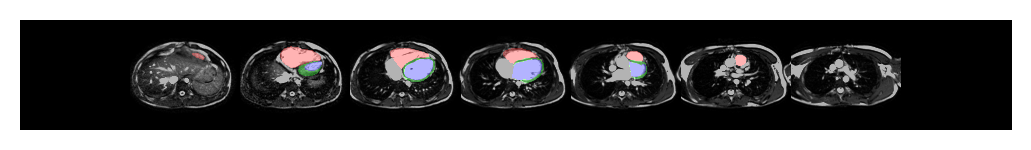

2020-11-20 09:10:44,557 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:10:44,630 INFO DICE LV: 0.9273093342781067
2020-11-20 09:10:44,703 INFO DICE RV: 0.8172563910484314
2020-11-20 09:10:44,773 INFO DICE MYO: 0.7285317778587341
2020-11-20 09:10:44,821 INFO m: [[ 0.7397 -0.5684  0.3618 -0.9263]
 [ 0.257   0.735   0.6284 -0.902 ]
 [-0.6226 -0.3716  0.689   6.24  ]]
2020-11-20 09:10:44,822 INFO m_mod: [[ 0.7397 -0.5684  0.3618 -0.4194]
 [ 0.257   0.735   0.6284 -0.632 ]
 [-0.6226 -0.3716  0.689  -0.5073]]
2020-11-20 09:10:44,822 INFO m_scaled: [[ 0.7397 -0.5684  0.3618 -0.839 ]
 [ 0.257   0.735   0.6284 -1.264 ]
 [-0.6226 -0.3716  0.689  -1.015 ]]
2020-11-20 09:10:44,823 INFO 0000-CKFQTQ9F_2006-11-10_ES_msk.nrrd
2020-11-20 09:10:44,823 INFO Prediction on AX volume:
2020-11-20 09:10:45,401 INFO AX --> SAX rotated by the model
2020-11-20 09:10:45,402 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:10:45,438 INFO Target (AX2SAX):


(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:10:45,441 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:10:47,419 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:10:47,421 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:10:48,352 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe0f8986e18> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:10:48,877 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:10:48,989 INFO DICE LV: 0.8747144341468811
2020-11-20 09:10:49,059 INFO DICE RV: 0.7341884970664978
2020-11-20 0

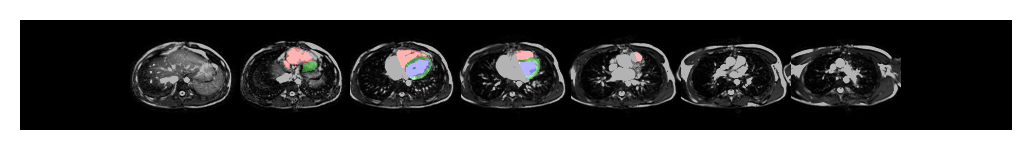

2020-11-20 09:10:49,929 INFO GT on AX


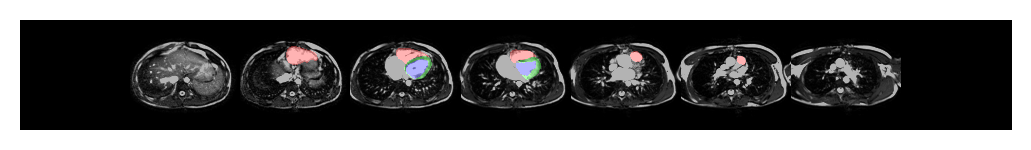

2020-11-20 09:10:50,294 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:10:50,367 INFO DICE LV: 0.8751758933067322
2020-11-20 09:10:50,437 INFO DICE RV: 0.7329015135765076
2020-11-20 09:10:50,508 INFO DICE MYO: 0.790705680847168
2020-11-20 09:10:50,555 INFO m: [[ 0.742  -0.5625  0.364  -0.9243]
 [ 0.2556  0.7397  0.622  -0.8994]
 [-0.6196 -0.369   0.6934  6.176 ]]
2020-11-20 09:10:50,555 INFO m_mod: [[ 0.742  -0.5625  0.364  -0.416 ]
 [ 0.2556  0.7397  0.622  -0.6284]
 [-0.6196 -0.369   0.6934 -0.504 ]]
2020-11-20 09:10:50,556 INFO m_scaled: [[ 0.742  -0.5625  0.364  -0.832 ]
 [ 0.2556  0.7397  0.622  -1.257 ]
 [-0.6196 -0.369   0.6934 -1.008 ]]
2020-11-20 09:10:50,556 INFO 0000-CUKYUVC2_2006-09-20_ED_msk.nrrd
2020-11-20 09:10:50,557 INFO Prediction on AX volume:
2020-11-20 09:10:51,114 INFO AX --> SAX rotated by the model
2020-11-20 09:10:51,117 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:10:51,161 INFO Target (AX2SAX):
2

(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:10:51,163 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:10:53,159 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:10:53,160 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:10:54,080 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe0f84306a8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:10:54,605 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:10:54,716 INFO DICE LV: 0.9127705097198486
2020-11-20 09:10:54,789 INFO DICE RV: 0.8699131011962891
2020-11-20 0

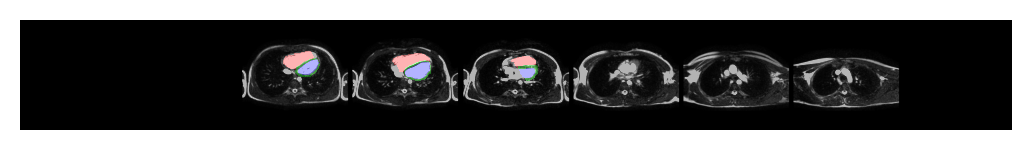

2020-11-20 09:10:55,660 INFO GT on AX


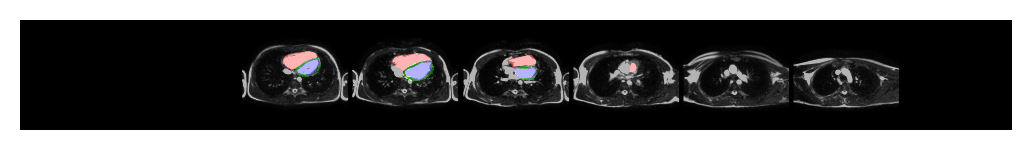

2020-11-20 09:10:56,023 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:10:56,095 INFO DICE LV: 0.9102717638015747
2020-11-20 09:10:56,166 INFO DICE RV: 0.8701810836791992
2020-11-20 09:10:56,237 INFO DICE MYO: 0.6835655570030212
2020-11-20 09:10:56,286 INFO m: [[ 0.7695 -0.5146  0.3784 -0.9043]
 [ 0.2435  0.7837  0.571  -0.8755]
 [-0.591  -0.347   0.7285  5.605 ]]
2020-11-20 09:10:56,286 INFO m_mod: [[ 0.7695 -0.5146  0.3784 -0.3862]
 [ 0.2435  0.7837  0.571  -0.593 ]
 [-0.591  -0.347   0.7285 -0.4702]]
2020-11-20 09:10:56,287 INFO m_scaled: [[ 0.7695 -0.5146  0.3784 -0.7725]
 [ 0.2435  0.7837  0.571  -1.186 ]
 [-0.591  -0.347   0.7285 -0.9404]]
2020-11-20 09:10:56,288 INFO 0000-CUKYUVC2_2006-09-20_ES_msk.nrrd
2020-11-20 09:10:56,288 INFO Prediction on AX volume:
2020-11-20 09:10:56,871 INFO AX --> SAX rotated by the model
2020-11-20 09:10:56,871 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:10:56,889 INFO Target (AX2SAX):


(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:10:56,891 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:10:58,882 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:10:58,884 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:10:59,806 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe0c483d6a8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:11:00,336 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:11:00,441 INFO DICE LV: 0.8557657599449158
2020-11-20 09:11:00,519 INFO DICE RV: 0.8333023190498352
2020-11-20 0

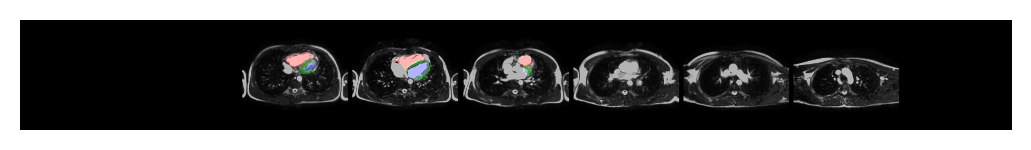

2020-11-20 09:11:01,383 INFO GT on AX


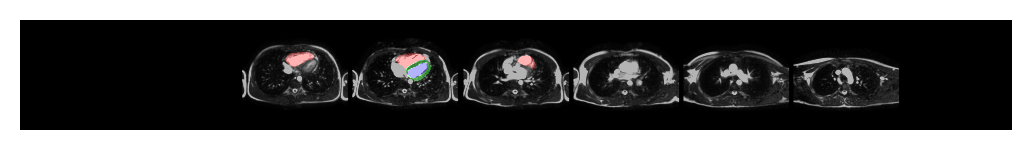

2020-11-20 09:11:01,754 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:11:01,831 INFO DICE LV: 0.8592180013656616
2020-11-20 09:11:01,902 INFO DICE RV: 0.8359789848327637
2020-11-20 09:11:01,974 INFO DICE MYO: 0.7361860275268555
2020-11-20 09:11:02,021 INFO m: [[ 0.7905 -0.477   0.3845 -0.885 ]
 [ 0.2338  0.8154  0.5303 -0.8535]
 [-0.566  -0.329   0.756   5.168 ]]
2020-11-20 09:11:02,022 INFO m_mod: [[ 0.7905 -0.477   0.3845 -0.3623]
 [ 0.2338  0.8154  0.5303 -0.5635]
 [-0.566  -0.329   0.756  -0.4434]]
2020-11-20 09:11:02,023 INFO m_scaled: [[ 0.7905 -0.477   0.3845 -0.7246]
 [ 0.2338  0.8154  0.5303 -1.127 ]
 [-0.566  -0.329   0.756  -0.8867]]
2020-11-20 09:11:02,023 INFO 0000-D9HN2LZW_2007-03-23_ED_msk.nrrd
2020-11-20 09:11:02,024 INFO Prediction on AX volume:
2020-11-20 09:11:02,610 INFO AX --> SAX rotated by the model
2020-11-20 09:11:02,611 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:11:02,646 INFO Target (AX2SAX):


(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:11:02,649 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:11:05,699 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:11:05,701 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:11:06,645 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe0c65df6a8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:11:07,180 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:11:07,291 INFO DICE LV: 0.9152467250823975
2020-11-20 09:11:07,362 INFO DICE RV: 0.7981840968132019
2020-11-20 0

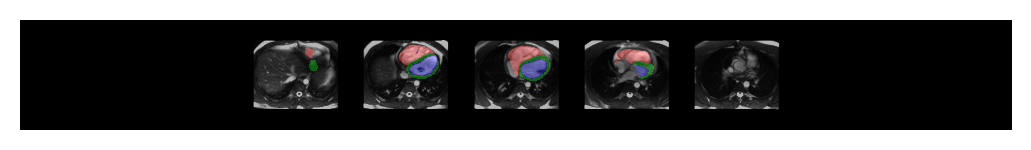

2020-11-20 09:11:08,262 INFO GT on AX


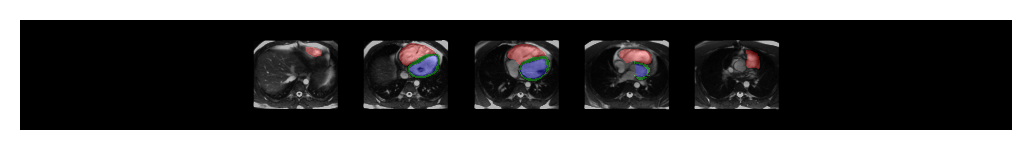

2020-11-20 09:11:08,630 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:11:08,704 INFO DICE LV: 0.9204161167144775
2020-11-20 09:11:08,775 INFO DICE RV: 0.7987428903579712
2020-11-20 09:11:08,847 INFO DICE MYO: 0.7134698033332825
2020-11-20 09:11:08,896 INFO m: [[ 0.8145 -0.434   0.3853 -0.8594]
 [ 0.2219  0.846   0.4846 -0.825 ]
 [-0.536  -0.309   0.7856  4.688 ]]
2020-11-20 09:11:08,896 INFO m_mod: [[ 0.8145 -0.434   0.3853 -0.335 ]
 [ 0.2219  0.846   0.4846 -0.5283]
 [-0.536  -0.309   0.7856 -0.4126]]
2020-11-20 09:11:08,897 INFO m_scaled: [[ 0.8145 -0.434   0.3853 -0.67  ]
 [ 0.2219  0.846   0.4846 -1.057 ]
 [-0.536  -0.309   0.7856 -0.825 ]]
2020-11-20 09:11:08,898 INFO 0000-D9HN2LZW_2007-03-23_ES_msk.nrrd
2020-11-20 09:11:08,898 INFO Prediction on AX volume:
2020-11-20 09:11:09,493 INFO AX --> SAX rotated by the model
2020-11-20 09:11:09,493 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:11:09,514 INFO Target (AX2SAX):


(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:11:09,517 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:11:11,521 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:11:11,523 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:11:12,458 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe0b574c6a8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:11:13,001 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:11:13,107 INFO DICE LV: 0.8265670537948608
2020-11-20 09:11:13,178 INFO DICE RV: 0.6701282858848572
2020-11-20 0

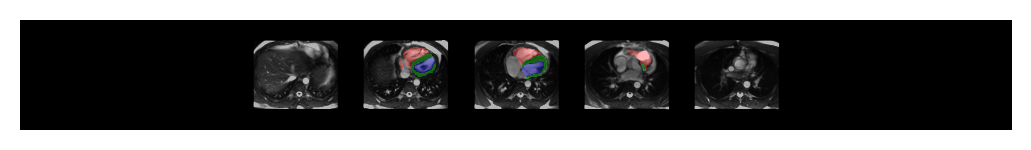

2020-11-20 09:11:14,039 INFO GT on AX


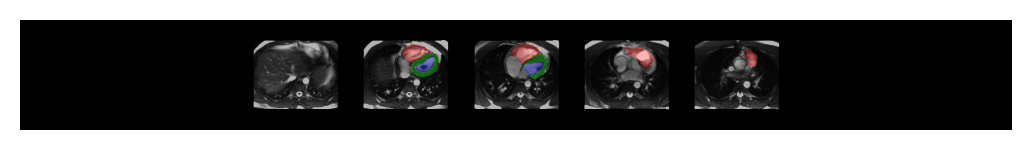

2020-11-20 09:11:14,401 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:11:14,473 INFO DICE LV: 0.8276818990707397
2020-11-20 09:11:14,543 INFO DICE RV: 0.6747415065765381
2020-11-20 09:11:14,614 INFO DICE MYO: 0.740390419960022
2020-11-20 09:11:14,662 INFO m: [[ 0.8066 -0.4473  0.3853 -0.867 ]
 [ 0.2258  0.8364  0.4988 -0.8345]
 [-0.5454 -0.3154  0.776   4.836 ]]
2020-11-20 09:11:14,662 INFO m_mod: [[ 0.8066 -0.4473  0.3853 -0.3438]
 [ 0.2258  0.8364  0.4988 -0.539 ]
 [-0.5454 -0.3154  0.776  -0.4219]]
2020-11-20 09:11:14,663 INFO m_scaled: [[ 0.8066 -0.4473  0.3853 -0.6875]
 [ 0.2258  0.8364  0.4988 -1.078 ]
 [-0.5454 -0.3154  0.776  -0.8438]]
2020-11-20 09:11:14,663 INFO 0000-E18NUCU2_2005-05-19_ED_msk.nrrd
2020-11-20 09:11:14,663 INFO Prediction on AX volume:
2020-11-20 09:11:15,246 INFO AX --> SAX rotated by the model
2020-11-20 09:11:15,248 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:11:15,303 INFO Target (AX2SAX):
2

(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:11:15,305 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:11:17,297 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:11:17,299 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:11:18,238 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe0fa23d730> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:11:18,766 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:11:18,871 INFO DICE LV: 0.9187938570976257
2020-11-20 09:11:18,948 INFO DICE RV: 0.832325279712677
2020-11-20 09

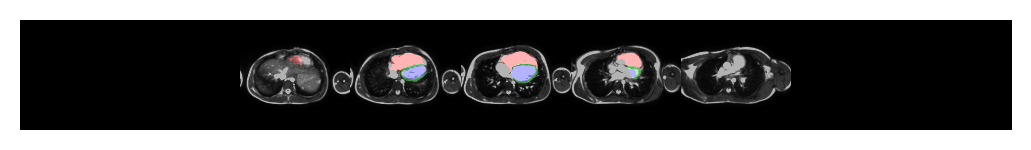

2020-11-20 09:11:19,832 INFO GT on AX


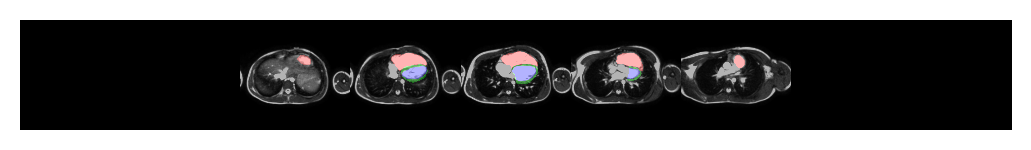

2020-11-20 09:11:20,205 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:11:20,283 INFO DICE LV: 0.9195701479911804
2020-11-20 09:11:20,355 INFO DICE RV: 0.8335269689559937
2020-11-20 09:11:20,427 INFO DICE MYO: 0.6826772093772888
2020-11-20 09:11:20,476 INFO m: [[ 0.7773 -0.5015  0.3816 -0.897 ]
 [ 0.2404  0.796   0.5566 -0.8677]
 [-0.582  -0.3408  0.739   5.438 ]]
2020-11-20 09:11:20,476 INFO m_mod: [[ 0.7773 -0.5015  0.3816 -0.3774]
 [ 0.2404  0.796   0.5566 -0.5815]
 [-0.582  -0.3408  0.739  -0.4604]]
2020-11-20 09:11:20,477 INFO m_scaled: [[ 0.7773 -0.5015  0.3816 -0.755 ]
 [ 0.2404  0.796   0.5566 -1.163 ]
 [-0.582  -0.3408  0.739  -0.921 ]]
2020-11-20 09:11:20,479 INFO 0000-E18NUCU2_2005-05-19_ES_msk.nrrd
2020-11-20 09:11:20,479 INFO Prediction on AX volume:
2020-11-20 09:11:21,056 INFO AX --> SAX rotated by the model
2020-11-20 09:11:21,057 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:11:21,087 INFO Target (AX2SAX):


(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:11:21,090 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:11:23,094 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:11:23,096 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:11:24,035 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe0f9f167b8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:11:24,578 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:11:24,683 INFO DICE LV: 0.8782919645309448
2020-11-20 09:11:24,755 INFO DICE RV: 0.7209031581878662
2020-11-20 0

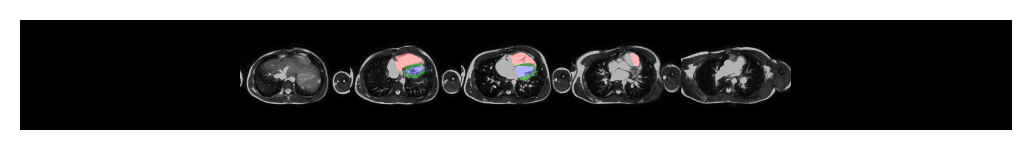

2020-11-20 09:11:25,633 INFO GT on AX


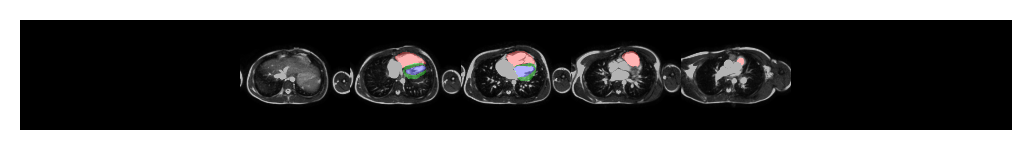

2020-11-20 09:11:26,000 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:11:26,071 INFO DICE LV: 0.8753858208656311
2020-11-20 09:11:26,144 INFO DICE RV: 0.7167061567306519
2020-11-20 09:11:26,216 INFO DICE MYO: 0.7166885733604431
2020-11-20 09:11:26,264 INFO m: [[ 0.7817 -0.493   0.3818 -0.8926]
 [ 0.2383  0.8022  0.5474 -0.863 ]
 [-0.576  -0.3372  0.7446  5.34  ]]
2020-11-20 09:11:26,265 INFO m_mod: [[ 0.7817 -0.493   0.3818 -0.3716]
 [ 0.2383  0.8022  0.5474 -0.575 ]
 [-0.576  -0.3372  0.7446 -0.454 ]]
2020-11-20 09:11:26,265 INFO m_scaled: [[ 0.7817 -0.493   0.3818 -0.743 ]
 [ 0.2383  0.8022  0.5474 -1.15  ]
 [-0.576  -0.3372  0.7446 -0.908 ]]
2020-11-20 09:11:26,266 INFO 0000-E8030CFZ_2007-01-03_ED_msk.nrrd
2020-11-20 09:11:26,266 INFO Prediction on AX volume:
2020-11-20 09:11:26,857 INFO AX --> SAX rotated by the model
2020-11-20 09:11:26,858 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:11:26,876 INFO Target (AX2SAX):


(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:11:26,878 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:11:28,888 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:11:28,890 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:11:29,827 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe0f4a708c8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:11:30,362 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:11:30,467 INFO DICE LV: 0.9174780249595642
2020-11-20 09:11:30,539 INFO DICE RV: 0.7566977143287659
2020-11-20 0

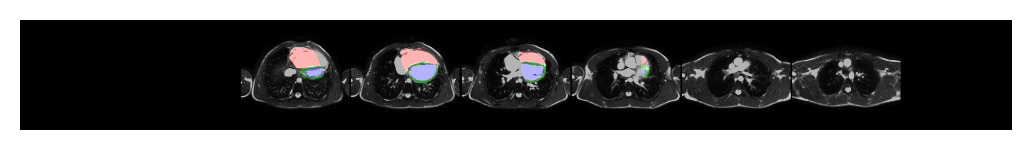

2020-11-20 09:11:31,408 INFO GT on AX


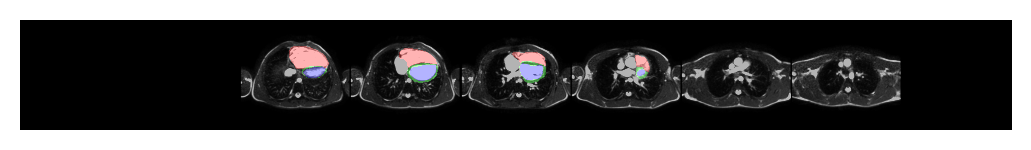

2020-11-20 09:11:31,773 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:11:31,843 INFO DICE LV: 0.9198595285415649
2020-11-20 09:11:31,914 INFO DICE RV: 0.7589171528816223
2020-11-20 09:11:31,984 INFO DICE MYO: 0.6734218001365662
2020-11-20 09:11:32,032 INFO m: [[ 0.771  -0.512   0.3787 -0.9023]
 [ 0.2434  0.786   0.5684 -0.8735]
 [-0.589  -0.346   0.731   5.562 ]]
2020-11-20 09:11:32,032 INFO m_mod: [[ 0.771  -0.512   0.3787 -0.3843]
 [ 0.2434  0.786   0.5684 -0.59  ]
 [-0.589  -0.346   0.731  -0.4683]]
2020-11-20 09:11:32,033 INFO m_scaled: [[ 0.771  -0.512   0.3787 -0.7686]
 [ 0.2434  0.786   0.5684 -1.18  ]
 [-0.589  -0.346   0.731  -0.9365]]
2020-11-20 09:11:32,034 INFO 0000-E8030CFZ_2007-01-03_ES_msk.nrrd
2020-11-20 09:11:32,034 INFO Prediction on AX volume:
2020-11-20 09:11:32,575 INFO AX --> SAX rotated by the model
2020-11-20 09:11:32,576 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:11:32,600 INFO Target (AX2SAX):


(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:11:32,602 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:11:34,607 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:11:34,608 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:11:35,550 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe0ab583ea0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:11:36,086 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:11:36,191 INFO DICE LV: 0.8519618511199951
2020-11-20 09:11:36,268 INFO DICE RV: 0.711296796798706
2020-11-20 09

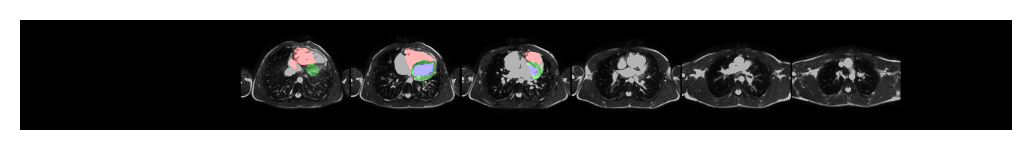

2020-11-20 09:11:37,157 INFO GT on AX


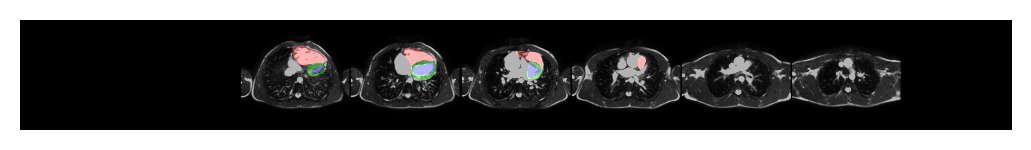

2020-11-20 09:11:37,534 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:11:37,612 INFO DICE LV: 0.8567798137664795
2020-11-20 09:11:37,685 INFO DICE RV: 0.712643563747406
2020-11-20 09:11:37,758 INFO DICE MYO: 0.7652916312217712
2020-11-20 09:11:37,806 INFO m: [[ 0.781  -0.4949  0.3816 -0.894 ]
 [ 0.2388  0.8003  0.55   -0.8643]
 [-0.5776 -0.3381  0.743   5.367 ]]
2020-11-20 09:11:37,807 INFO m_mod: [[ 0.781  -0.4949  0.3816 -0.3735]
 [ 0.2388  0.8003  0.55   -0.5767]
 [-0.5776 -0.3381  0.743  -0.4556]]
2020-11-20 09:11:37,807 INFO m_scaled: [[ 0.781  -0.4949  0.3816 -0.747 ]
 [ 0.2388  0.8003  0.55   -1.153 ]
 [-0.5776 -0.3381  0.743  -0.911 ]]
2020-11-20 09:11:37,810 INFO 0000-GZ4M6Z9G_2006-12-07_ED_msk.nrrd
2020-11-20 09:11:37,810 INFO Prediction on AX volume:
2020-11-20 09:11:38,403 INFO AX --> SAX rotated by the model
2020-11-20 09:11:38,406 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:11:38,447 INFO Target (AX2SAX):
2

(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:11:38,450 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:11:40,495 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:11:40,497 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:11:41,450 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe0a9fe5f28> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:11:41,993 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:11:42,099 INFO DICE LV: 0.9223398566246033
2020-11-20 09:11:42,177 INFO DICE RV: 0.7955741882324219
2020-11-20 0

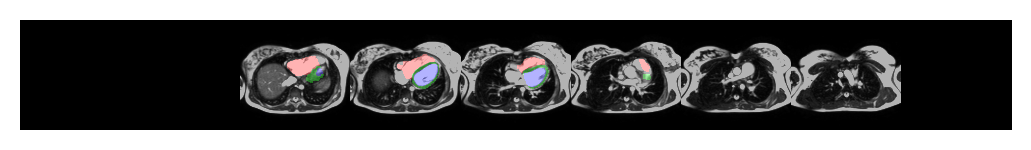

2020-11-20 09:11:43,088 INFO GT on AX


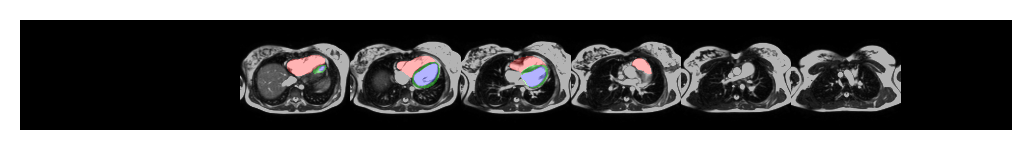

2020-11-20 09:11:43,458 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:11:43,537 INFO DICE LV: 0.9309359788894653
2020-11-20 09:11:43,609 INFO DICE RV: 0.7958586812019348
2020-11-20 09:11:43,680 INFO DICE MYO: 0.7345512509346008
2020-11-20 09:11:43,728 INFO m: [[ 0.7466 -0.5537  0.3674 -0.921 ]
 [ 0.2534  0.748   0.613  -0.8955]
 [-0.6147 -0.3645  0.699   6.074 ]]
2020-11-20 09:11:43,729 INFO m_mod: [[ 0.7466 -0.5537  0.3674 -0.4111]
 [ 0.2534  0.748   0.613  -0.622 ]
 [-0.6147 -0.3645  0.699  -0.498 ]]
2020-11-20 09:11:43,743 INFO m_scaled: [[ 0.7466 -0.5537  0.3674 -0.8223]
 [ 0.2534  0.748   0.613  -1.244 ]
 [-0.6147 -0.3645  0.699  -0.996 ]]
2020-11-20 09:11:43,743 INFO 0000-GZ4M6Z9G_2006-12-07_ES_msk.nrrd
2020-11-20 09:11:43,743 INFO Prediction on AX volume:
2020-11-20 09:11:44,342 INFO AX --> SAX rotated by the model
2020-11-20 09:11:44,342 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:11:44,360 INFO Target (AX2SAX):


(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:11:44,362 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:11:46,352 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:11:46,354 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:11:47,295 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe0a8bc2ae8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:11:47,839 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:11:47,950 INFO DICE LV: 0.8520562052726746
2020-11-20 09:11:48,020 INFO DICE RV: 0.6274895071983337
2020-11-20 0

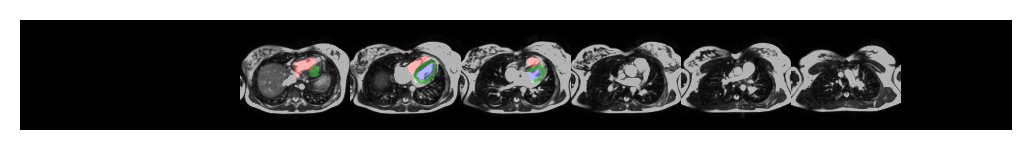

2020-11-20 09:11:48,888 INFO GT on AX


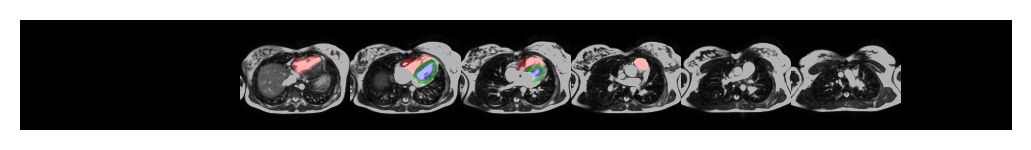

2020-11-20 09:11:49,256 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:11:49,330 INFO DICE LV: 0.859776496887207
2020-11-20 09:11:49,402 INFO DICE RV: 0.6237934231758118
2020-11-20 09:11:49,472 INFO DICE MYO: 0.7616257667541504
2020-11-20 09:11:49,521 INFO m: [[ 0.7466 -0.5537  0.3674 -0.9214]
 [ 0.2534  0.748   0.613  -0.8955]
 [-0.6147 -0.3647  0.699   6.08  ]]
2020-11-20 09:11:49,522 INFO m_mod: [[ 0.7466 -0.5537  0.3674 -0.4111]
 [ 0.2534  0.748   0.613  -0.6226]
 [-0.6147 -0.3647  0.699  -0.498 ]]
2020-11-20 09:11:49,522 INFO m_scaled: [[ 0.7466 -0.5537  0.3674 -0.8223]
 [ 0.2534  0.748   0.613  -1.245 ]
 [-0.6147 -0.3647  0.699  -0.996 ]]
2020-11-20 09:11:49,523 INFO 0000-HNE7CVMU_2006-10-27_ED_msk.nrrd
2020-11-20 09:11:49,523 INFO Prediction on AX volume:
2020-11-20 09:11:50,093 INFO AX --> SAX rotated by the model
2020-11-20 09:11:50,093 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:11:50,111 INFO Target (AX2SAX):
2

(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:11:50,113 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:11:52,105 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:11:52,107 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:11:53,041 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe08de25ae8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:11:53,574 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:11:53,679 INFO DICE LV: 0.8530049920082092
2020-11-20 09:11:53,750 INFO DICE RV: 0.7236703038215637
2020-11-20 0

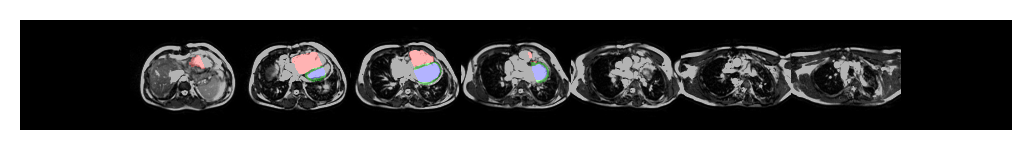

2020-11-20 09:11:54,620 INFO GT on AX


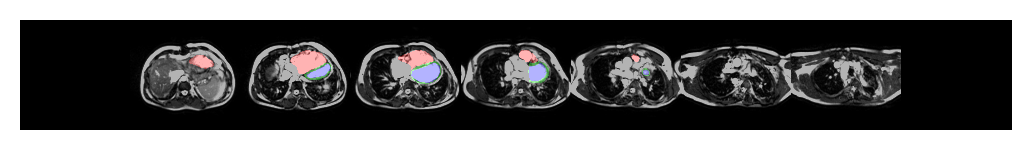

2020-11-20 09:11:54,987 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:11:55,059 INFO DICE LV: 0.8494105339050293
2020-11-20 09:11:55,129 INFO DICE RV: 0.7294738292694092
2020-11-20 09:11:55,200 INFO DICE MYO: 0.6401017308235168
2020-11-20 09:11:55,248 INFO m: [[ 0.727  -0.5894  0.3528 -0.9346]
 [ 0.2617  0.713   0.651  -0.9116]
 [-0.635  -0.3806  0.6724  6.516 ]]
2020-11-20 09:11:55,249 INFO m_mod: [[ 0.727  -0.5894  0.3528 -0.4336]
 [ 0.2617  0.713   0.651  -0.6484]
 [-0.635  -0.3806  0.6724 -0.5225]]
2020-11-20 09:11:55,249 INFO m_scaled: [[ 0.727  -0.5894  0.3528 -0.867 ]
 [ 0.2617  0.713   0.651  -1.297 ]
 [-0.635  -0.3806  0.6724 -1.045 ]]
2020-11-20 09:11:55,250 INFO 0000-HNE7CVMU_2006-10-27_ES_msk.nrrd
2020-11-20 09:11:55,250 INFO Prediction on AX volume:
2020-11-20 09:11:55,841 INFO AX --> SAX rotated by the model
2020-11-20 09:11:55,842 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:11:55,874 INFO Target (AX2SAX):


(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:11:55,876 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:11:57,874 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:11:57,875 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:11:58,812 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe08c1bfa60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:11:59,352 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:11:59,458 INFO DICE LV: 0.8467949032783508
2020-11-20 09:11:59,535 INFO DICE RV: 0.6515082120895386
2020-11-20 0

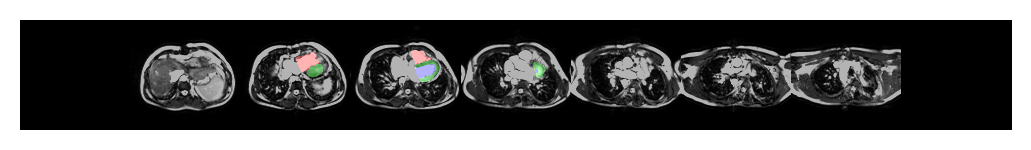

2020-11-20 09:12:00,419 INFO GT on AX


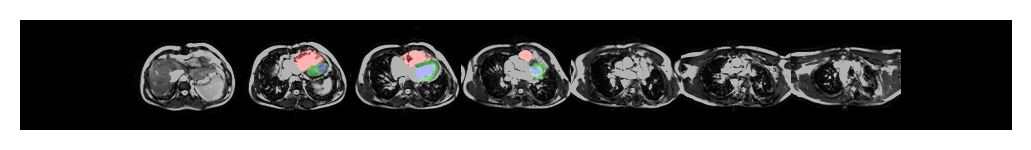

2020-11-20 09:12:00,791 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:12:00,861 INFO DICE LV: 0.8434333205223083
2020-11-20 09:12:00,929 INFO DICE RV: 0.6468939781188965
2020-11-20 09:12:00,997 INFO DICE MYO: 0.7883397936820984
2020-11-20 09:12:01,045 INFO m: [[ 0.718  -0.6045  0.3452 -0.94  ]
 [ 0.2651  0.696   0.6675 -0.918 ]
 [-0.6436 -0.3875  0.6597  6.715 ]]
2020-11-20 09:12:01,046 INFO m_mod: [[ 0.718  -0.6045  0.3452 -0.4434]
 [ 0.2651  0.696   0.6675 -0.659 ]
 [-0.6436 -0.3875  0.6597 -0.533 ]]
2020-11-20 09:12:01,046 INFO m_scaled: [[ 0.718  -0.6045  0.3452 -0.8867]
 [ 0.2651  0.696   0.6675 -1.318 ]
 [-0.6436 -0.3875  0.6597 -1.066 ]]
2020-11-20 09:12:01,047 INFO 0000-KK9VRLND_2006-07-10_ED_msk.nrrd
2020-11-20 09:12:01,047 INFO Prediction on AX volume:
2020-11-20 09:12:01,592 INFO AX --> SAX rotated by the model
2020-11-20 09:12:01,593 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:12:01,612 INFO Target (AX2SAX):


(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:12:01,614 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:12:03,625 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:12:03,627 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:12:04,563 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe08b635e18> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:12:05,093 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:12:05,200 INFO DICE LV: 0.8743617534637451
2020-11-20 09:12:05,271 INFO DICE RV: 0.7967588305473328
2020-11-20 0

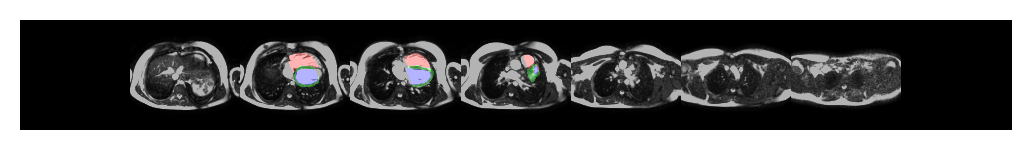

2020-11-20 09:12:06,147 INFO GT on AX


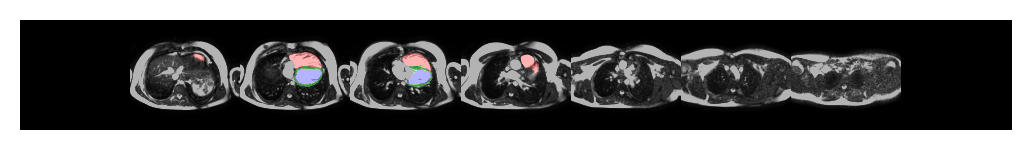

2020-11-20 09:12:06,516 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:12:06,588 INFO DICE LV: 0.8757615685462952
2020-11-20 09:12:06,661 INFO DICE RV: 0.7938244938850403
2020-11-20 09:12:06,735 INFO DICE MYO: 0.6171310544013977
2020-11-20 09:12:06,784 INFO m: [[ 0.709  -0.621   0.3354 -0.945 ]
 [ 0.2693  0.6772  0.685  -0.924 ]
 [-0.6523 -0.3955  0.6475  6.926 ]]
2020-11-20 09:12:06,785 INFO m_mod: [[ 0.709  -0.621   0.3354 -0.4536]
 [ 0.2693  0.6772  0.685  -0.671 ]
 [-0.6523 -0.3955  0.6475 -0.5444]]
2020-11-20 09:12:06,785 INFO m_scaled: [[ 0.709  -0.621   0.3354 -0.907 ]
 [ 0.2693  0.6772  0.685  -1.342 ]
 [-0.6523 -0.3955  0.6475 -1.089 ]]
2020-11-20 09:12:06,786 INFO 0000-KK9VRLND_2006-07-10_ES_msk.nrrd
2020-11-20 09:12:06,787 INFO Prediction on AX volume:
2020-11-20 09:12:07,384 INFO AX --> SAX rotated by the model
2020-11-20 09:12:07,387 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:12:07,435 INFO Target (AX2SAX):


(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:12:07,438 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:12:09,441 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:12:09,443 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:12:10,362 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe08a03df28> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:12:10,892 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:12:10,997 INFO DICE LV: 0.749250054359436
2020-11-20 09:12:11,068 INFO DICE RV: 0.5983344912528992
2020-11-20 09

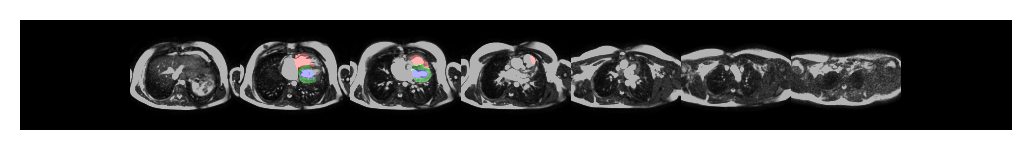

2020-11-20 09:12:11,937 INFO GT on AX


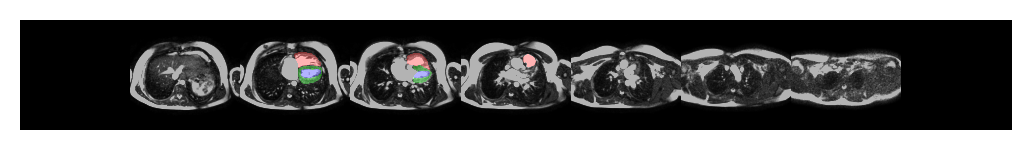

2020-11-20 09:12:12,309 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:12:12,387 INFO DICE LV: 0.7534969449043274
2020-11-20 09:12:12,458 INFO DICE RV: 0.5974776148796082
2020-11-20 09:12:12,529 INFO DICE MYO: 0.6658167243003845
2020-11-20 09:12:12,577 INFO m: [[ 0.711  -0.617   0.3376 -0.944 ]
 [ 0.2683  0.6816  0.6807 -0.923 ]
 [-0.6504 -0.3933  0.65    6.88  ]]
2020-11-20 09:12:12,577 INFO m_mod: [[ 0.711  -0.617   0.3376 -0.4512]
 [ 0.2683  0.6816  0.6807 -0.668 ]
 [-0.6504 -0.3933  0.65   -0.542 ]]
2020-11-20 09:12:12,578 INFO m_scaled: [[ 0.711  -0.617   0.3376 -0.9023]
 [ 0.2683  0.6816  0.6807 -1.336 ]
 [-0.6504 -0.3933  0.65   -1.084 ]]
2020-11-20 09:12:12,580 INFO 0000-TET48V2Z_2008-01-10_ED_msk.nrrd
2020-11-20 09:12:12,580 INFO Prediction on AX volume:
2020-11-20 09:12:13,174 INFO AX --> SAX rotated by the model
2020-11-20 09:12:13,175 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:12:13,229 INFO Target (AX2SAX):


(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:12:13,232 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:12:15,250 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:12:15,252 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:12:16,189 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe087b19950> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:12:16,718 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:12:16,834 INFO DICE LV: 0.9201080203056335
2020-11-20 09:12:16,906 INFO DICE RV: 0.8492141962051392
2020-11-20 0

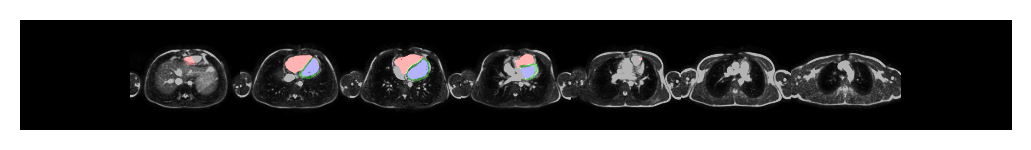

2020-11-20 09:12:20,137 INFO GT on AX


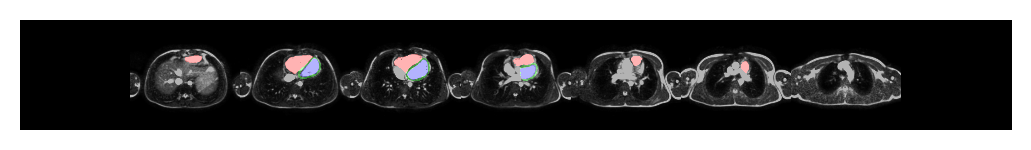

2020-11-20 09:12:20,507 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:12:20,563 INFO DICE LV: 0.91773921251297
2020-11-20 09:12:20,619 INFO DICE RV: 0.8454455137252808
2020-11-20 09:12:20,673 INFO DICE MYO: 0.6937475204467773
2020-11-20 09:12:20,710 INFO m: [[ 0.7705 -0.512   0.379  -0.9023]
 [ 0.2433  0.786   0.568  -0.874 ]
 [-0.589  -0.3455  0.7305  5.566 ]]
2020-11-20 09:12:20,710 INFO m_mod: [[ 0.7705 -0.512   0.379  -0.3843]
 [ 0.2433  0.786   0.568  -0.59  ]
 [-0.589  -0.3455  0.7305 -0.4683]]
2020-11-20 09:12:20,711 INFO m_scaled: [[ 0.7705 -0.512   0.379  -0.7686]
 [ 0.2433  0.786   0.568  -1.18  ]
 [-0.589  -0.3455  0.7305 -0.9365]]
2020-11-20 09:12:20,713 INFO 0000-TET48V2Z_2008-01-10_ES_msk.nrrd
2020-11-20 09:12:20,713 INFO Prediction on AX volume:
2020-11-20 09:12:21,295 INFO AX --> SAX rotated by the model
2020-11-20 09:12:21,296 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:12:21,314 INFO Target (AX2SAX):
20

(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:12:21,315 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:12:23,412 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:12:23,413 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:12:24,408 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe0fb69e2f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:12:24,949 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:12:25,040 INFO DICE LV: 0.8672547340393066
2020-11-20 09:12:25,100 INFO DICE RV: 0.7628839015960693
2020-11-20 0

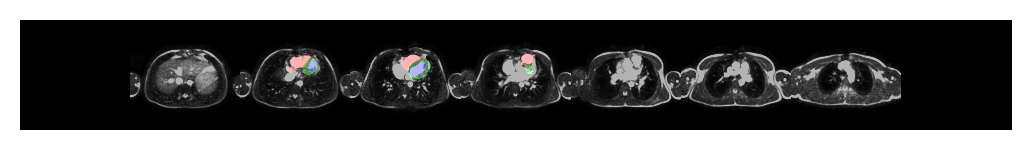

2020-11-20 09:12:25,929 INFO GT on AX


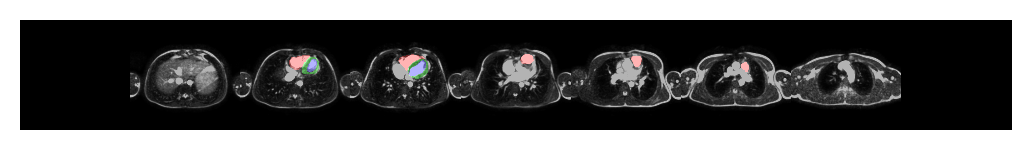

2020-11-20 09:12:26,303 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:12:26,362 INFO DICE LV: 0.8682423233985901
2020-11-20 09:12:26,428 INFO DICE RV: 0.7630353569984436
2020-11-20 09:12:26,487 INFO DICE MYO: 0.7337175011634827
2020-11-20 09:12:26,523 INFO m: [[ 0.7803 -0.4958  0.3818 -0.8945]
 [ 0.239   0.8     0.551  -0.8647]
 [-0.578  -0.3381  0.7427  5.375 ]]
2020-11-20 09:12:26,523 INFO m_mod: [[ 0.7803 -0.4958  0.3818 -0.374 ]
 [ 0.239   0.8     0.551  -0.5776]
 [-0.578  -0.3381  0.7427 -0.4565]]
2020-11-20 09:12:26,524 INFO m_scaled: [[ 0.7803 -0.4958  0.3818 -0.748 ]
 [ 0.239   0.8     0.551  -1.155 ]
 [-0.578  -0.3381  0.7427 -0.913 ]]
2020-11-20 09:12:26,524 INFO 0000-Z0QR21CJ_2005-11-02_ED_msk.nrrd
2020-11-20 09:12:26,525 INFO Prediction on AX volume:
2020-11-20 09:12:27,086 INFO AX --> SAX rotated by the model
2020-11-20 09:12:27,086 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:12:27,104 INFO Target (AX2SAX):


(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:12:27,106 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:12:29,145 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:12:29,146 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:12:30,117 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe0f528a400> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:12:30,642 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:12:30,734 INFO DICE LV: 0.8563743233680725
2020-11-20 09:12:30,794 INFO DICE RV: 0.7863863706588745
2020-11-20 0

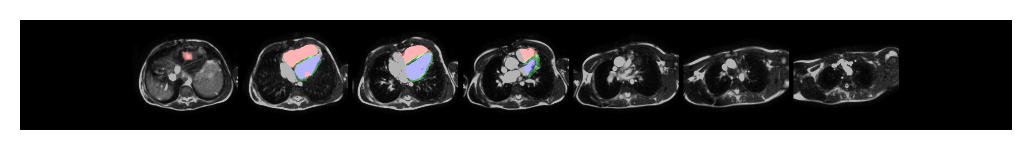

2020-11-20 09:12:31,628 INFO GT on AX


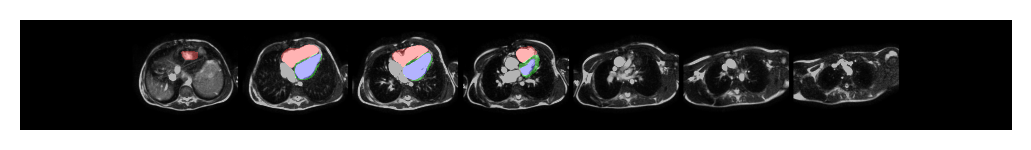

2020-11-20 09:12:31,996 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:12:32,057 INFO DICE LV: 0.8600951433181763
2020-11-20 09:12:32,117 INFO DICE RV: 0.7777770161628723
2020-11-20 09:12:32,175 INFO DICE MYO: 0.6025077104568481
2020-11-20 09:12:32,210 INFO m: [[ 0.751  -0.5474  0.369  -0.9185]
 [ 0.252   0.7544  0.606  -0.8926]
 [-0.6104 -0.362   0.704   5.992 ]]
2020-11-20 09:12:32,211 INFO m_mod: [[ 0.751  -0.5474  0.369  -0.4067]
 [ 0.252   0.7544  0.606  -0.617 ]
 [-0.6104 -0.362   0.704  -0.4932]]
2020-11-20 09:12:32,211 INFO m_scaled: [[ 0.751  -0.5474  0.369  -0.8135]
 [ 0.252   0.7544  0.606  -1.234 ]
 [-0.6104 -0.362   0.704  -0.9863]]
2020-11-20 09:12:32,212 INFO 0000-Z0QR21CJ_2005-11-02_ES_msk.nrrd
2020-11-20 09:12:32,212 INFO Prediction on AX volume:
2020-11-20 09:12:32,780 INFO AX --> SAX rotated by the model
2020-11-20 09:12:32,783 INFO AX --> SAX with modified m rotated by the model
2020-11-20 09:12:32,826 INFO Target (AX2SAX):


(3, 4)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:12:32,829 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-11-20 09:12:34,852 INFO Predicted mask


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:12:34,854 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2020-11-20 09:12:35,809 WARNING 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe0c7f1d378> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2020-11-20 09:12:36,335 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-20 09:12:36,427 INFO DICE LV: 0.7586530447006226
2020-11-20 09:12:36,486 INFO DICE RV: 0.6639696955680847
2020-11-20 0

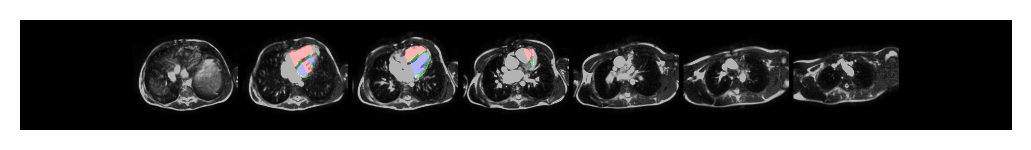

2020-11-20 09:12:37,324 INFO GT on AX


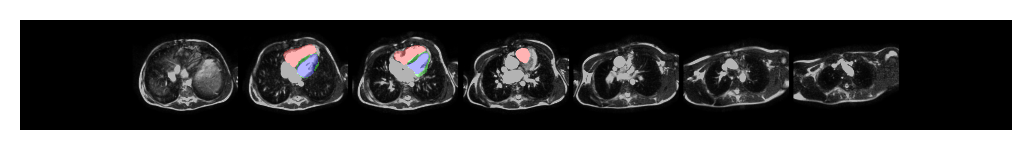

2020-11-20 09:12:37,691 INFO inv mask shape: (128, 224, 224, 4), gt mask shape: (128, 224, 224, 3)
2020-11-20 09:12:37,746 INFO DICE LV: 0.755035936832428
2020-11-20 09:12:37,803 INFO DICE RV: 0.6519684791564941
2020-11-20 09:12:37,859 INFO DICE MYO: 0.6021973490715027
2020-11-20 09:12:37,894 INFO m: [[ 0.771  -0.511   0.3792 -0.9023]
 [ 0.243   0.7866  0.5674 -0.8735]
 [-0.5884 -0.3452  0.7314  5.56  ]]
2020-11-20 09:12:37,895 INFO m_mod: [[ 0.771  -0.511   0.3792 -0.3843]
 [ 0.243   0.7866  0.5674 -0.59  ]
 [-0.5884 -0.3452  0.7314 -0.4678]]
2020-11-20 09:12:37,895 INFO m_scaled: [[ 0.771  -0.511   0.3792 -0.7686]
 [ 0.243   0.7866  0.5674 -1.18  ]
 [-0.5884 -0.3452  0.7314 -0.9355]]


In [21]:
# predict on all test images, once with postprocessing, and once without
use_modified_translation = FOCUS_LOSS # True, if we use the unet extension to learn a second set of translation parameters
combine = False
dual_model = False

logging.info('use modified translation to scale: {}'.format(use_modified_translation))
#path_1 = 'data/predicted/papernewcrop_baseline_1ax_1sax_01focus_inplane/3D/'
path_1 = 'data/predicted/tests_downsample_center64_112_112_sp3_1ax_1sax_1focus_thres09_NOinpl_f2/3D/'

#path_1 = 'data/predicted/temp2_post/3D/'
path_2 = path_1.replace('_post', '_NoPost')
for i in range(ax_full.shape[0]):
    select_image_in_batch_(im=i,slice_n=5, debug=False,export_path=path_1, save=True, postprocess=True, use_mod_translation=use_modified_translation, combine=combine, dual_model=dual_model)
    #select_image_in_batch_(im=i,slice_n=5, debug=False,export_path=path_2, save=True, postprocess=False)

In [ ]:
# Initial version, please check before execute
assert(False==True)
@interact
def select_image_in_batch(im=(0, x_.shape[0] - 1, 1), 
                          slice_n=(1, 6), 
                          export_path='data/predicted/temp/',
                          shift_z=20,
                          debug=False,
                         save=False):
    """
    Use the spatial transformer to rotate, predict segmentations, reverse the rotation on the masks and save the nrrd files (image, gt and pred)
    :param im: slider to select another image from the generator
    :param slice_n: The show_2D_3D method slices to a maximum of 20 slices in z, this parameter allows to further slice the visualisations
    :param export_path: path to save the img, gt and prediction volumes as nrrd file, the file names will be the same as in x_ax_val...
    :param debug: bool to enable plotting of the intermediate steps
    :return: void
    """
    global m

    full_file_name = y_val_ax[im]
    filename = os.path.basename(full_file_name)
    logging.info(filename)
    temp = x_[im]
    temp_ = y_[im]
    ax_full_ = ax_full[im]
    ax_msk_full_gt = ax_msk_[im]
    
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Prediction on AX volume:')
    if debug: show_2D_or_3D(temp[::slice_n])
    plt.show()
    
    # Predict rotation of AX and get transformation matrix
    logging.info('AX --> SAX rotated by the model')
    pred, m, mask_pred= model.predict(np.expand_dims(temp, axis=0))
    if debug: show_2D_or_3D(pred[0][::slice_n])
    plt.show()
    
    # make copy of m for reusage
    #m_ = m.copy()
    m = np.reshape(m, (3,4))
    # scale translation part of the affine matrix from spacing 5 to 1.5
    m_t = m[:,3]
    m_t = (m_t *5)/1.5
    m[:,3] = m_t
    m_ = m.flatten()
    
    # show the target AXtoSAX volume
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Target (SAX):')
    if debug: show_2D_or_3D(temp_[::slice_n])
    plt.show()
    
    # Repeat the transformation on ax with full resolution
    logging.info('Repeat the transformation on the full resolution')
    logging.getLogger().setLevel(logging.ERROR)
    transformer = create_affine_transformer_fixed(config=msk_cfg, interp_method='linear')
    pred, m_ = transformer.predict(x=[np.expand_dims(ax_full_, axis=0), np.expand_dims(m_,axis=0)])
    if debug: show_2D_or_3D(pred[0][::slice_n*3])
    plt.show()
    
    # reshape m to matrix
    m = np.reshape(m, (3, 4))

    # create a square ident matrix slice m into it
    m_matrix = np.identity(4)
    # slice m (3,4) into identity (4,4)
    m_matrix[:3, :] = m
    # calc inverse, flatten the matrix and cut off the last row for the spatial transformer
    m_matrix_inverse = np.linalg.inv(m_matrix)
    m_matrix_inverse_flatten = m_matrix_inverse.flatten()[:-4]

    # apply the inverse to our AXtoSAX volume
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Apply the invers rotation to our AXtoSAX')
    logging.getLogger().setLevel(logging.ERROR)
    inv, _ = transformer.predict(x=[pred, np.expand_dims(m_matrix_inverse_flatten, axis=0)])
    if debug: show_2D_or_3D(inv[0][::slice_n*3])
    plt.show()

    # load a 3D wrapper model for segmenting the new SAX
    if 'unet' in globals():
        msk = unet.predict(x=pred)
        msk = clean_3d_prediction_3d_cc(from_channel_to_flat(msk[0] >= 0.5))
        msk = transform_to_binary_mask(msk)
        logging.getLogger().setLevel(logging.INFO)
        logging.info('Predicted mask')
        if debug: show_2D_or_3D(pred[0][::slice_n*3], msk[::slice_n*3])
        plt.show()

        # apply inverse to our msk and plot it together with the inverse AXtoSAX
        logging.getLogger().setLevel(logging.ERROR)
        m_transformer = create_affine_transformer_fixed(config=msk_cfg, interp_method='nearest')
        inv_msk = list()
        for c in range(msk.shape[-1]):
            inv_m, _ = m_transformer.predict(
                x=[np.expand_dims(msk[..., c], axis=0), np.expand_dims(m_matrix_inverse_flatten, axis=0)])
            inv_msk.append(inv_m[..., 0] >= 0.5)
        inv_msk = np.stack(inv_msk, axis=-1)
        
        # postprocessing
        logging.getLogger().setLevel(logging.INFO)
        logging.info('Predicted mask rotated to AX on original AX image - before postprocessing')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[0][::slice_n*3])
        plt.show()
        
        inv_msk = from_channel_to_flat(inv_msk[0])
        kernel = np.ones((5,5),np.uint8)
        kernel_small = np.ones((3,3),np.uint8)
        
        inv_msk = clean_3d_prediction_3d_cc(inv_msk)
        logging.info('Predicted mask rotated to AX on original AX image - after connected component filtering')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        
        inv_msk = np.stack([cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel_small) for img in inv_msk],axis=0)
        logging.info('Predicted mask rotated to AX on original AX image - after closing')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        
        inv_msk = np.stack([cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=2) for img in inv_msk],axis=0)
        logging.info('Predicted mask rotated to AX on original AX image - after opening')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        
        inv_msk = np.stack([cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel) for img in inv_msk],axis=0)
        logging.info('Predicted mask rotated to AX on original AX image - after closing')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        
        inv_msk = clean_3d_prediction_3d_cc(inv_msk)
        logging.info('Predicted mask rotated to AX on original AX image - after connected component filtering')
        if debug: show_2D_or_3D(ax_full_, inv_msk)
        plt.show()

        logging.getLogger().setLevel(logging.INFO)
        logging.info('Predicted mask rotated to AX on inverse AXtoSAX')
        if debug: show_2D_or_3D(inv[0][::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        logging.info('Predicted mask rotated to AX on original AX image')
        show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        
        # get the AX target segmentation, processed by the generator to have it in the same shape
        #msk_flatten = clean_3d_prediction_3d_cc(from_channel_to_flat(inv_msk[0]))
        msk_gt_flatten = from_channel_to_flat(ax_msk_full_gt)
        logging.info('GT on AX')
        show_2D_or_3D(ax_full_[::slice_n*3], msk_gt_flatten[::slice_n*3])
        plt.show()
        
        # create a nrrd file for the gt, pred and image volume
        sitk_pred = sitk.GetImageFromArray(inv_msk)
        sitk_ax_img = sitk.GetImageFromArray(ax_full_)
        sitk_ax_msk = sitk.GetImageFromArray(msk_gt_flatten)

        ensure_dir(os.path.join(export_path, 'pred'))
        ensure_dir(os.path.join(export_path, 'image'))
        ensure_dir(os.path.join(export_path, 'gt'))
        
        # load a reference nrrd file, copy all metadata and save the volumes
        reference_sitk = sitk.ReadImage(full_file_name)
        if save:
            copy_meta_and_save(sitk_pred, reference_sitk, os.path.join(export_path, 'pred', filename))
            copy_meta_and_save(sitk_ax_img, reference_sitk,os.path.join(export_path, 'image', filename.replace('msk', 'img')))
            copy_meta_and_save(sitk_ax_msk, reference_sitk, os.path.join(export_path, 'gt', filename))
        # shutil.copyfile(full_file_name, os.path.join(export_path, 'gt', filename))
    else:
        logging.info('no unet in global namespace, segmentation is not possible')

    logging.info('MSE: {}'.format(mse(pred[0], ax_full_).numpy().mean()))
    #logging.info('MSE center cube: {}'.format(metr.cubic_center_loss_wrapper(pred[0], temp_).numpy().mean()))
    try:
        print(np.reshape(m[0], (3, 4)))
    except Exception as e:
        pass


In [26]:
gt.shape

(128, 224, 224, 3)

In [29]:
zero = np.zeros_like(gt[...,0:1])
temp = np.concatenate((zero,gt),axis=-1)
temp.shape

(128, 224, 224, 4)

In [30]:
import medpy
myos = [metr.dice_coef_myo(g, p).numpy() for g,p in zip(gt, pred)]
myos_gt = [int(not g.max()) for g in gt[...,1]]
lvs = [metr.dice_coef_lv(g, p).numpy() for g,p in zip(gt, pred)]
lvs_gt = [int(not g.max()) for g in gt[...,2]]
rvs = [metr.dice_coef_rv(g, p).numpy() for g,p in zip(gt, pred)]
rvs_gt = [int(not g.max()) for g in gt[...,0]]

In [31]:
myos = [metr.dice_coef_myo(g, p).numpy() for g,p in zip(gt, pred)]
myos_gt = [int(not g.max()) for g in gt[...,1]]
lvs = [metr.dice_coef_lv(g, p).numpy() for g,p in zip(gt, pred)]
lvs_gt = [int(not g.max()) for g in gt[...,2]]
rvs = [metr.dice_coef_rv(g, p).numpy() for g,p in zip(gt, pred)]
rvs_gt = [int(not g.max()) for g in gt[...,0]]

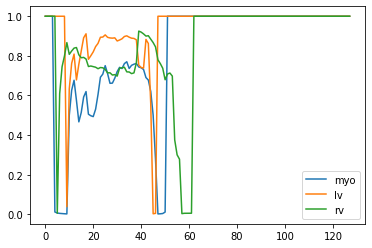

In [32]:
plt.plot(myos, label='myo')
#plt.plot(myos_gt, label='myo gt')
plt.plot(lvs, label='lv')
plt.plot(rvs, label='rv')
plt.legend()
plt.show()


In [33]:
scores = list(zip(lvs, lvs_gt, myos,myos_gt, rvs, rvs_gt))
scores[50]

(1.0, 1, 0.011235955, 1, 0.67941415, 0)

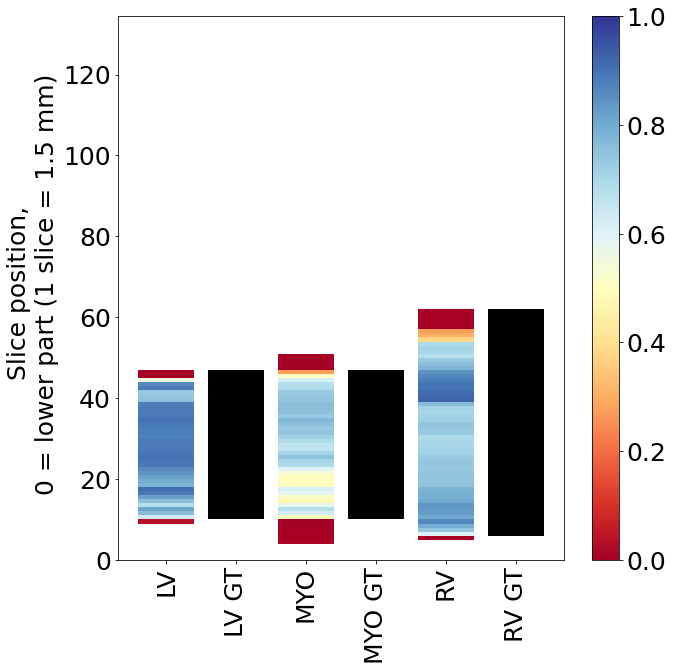

In [34]:
import matplotlib
plt.rcParams.update({'font.size':25})
bottom=0
cmap = matplotlib.cm.get_cmap('RdYlBu')
def custom_map(value):
    
    colors = []
    for v in value:
        
        # start with white
        color = (1,1,1,0)
        
        # 1 is reserved for slices with no label
        if v<1:
            # use black for the gt bars
            if v == 0:
                color = (0,0,0,1)
            # use bthe colorbar for the dice
            else:
                color = cmap(v)

        colors.append(color)
    
    #color = [cmap(v) if v <1 else (1,1,1,0) for v in value]
    return colors
        
fig, ax = plt.subplots(figsize=(10,10))
elements = range(len(scores))
for v in scores:
    rects = ax.bar([0,1,2,3,4,5],1,bottom=bottom, color=custom_map(v))
    bottom+=1
fig.colorbar(matplotlib.cm.ScalarMappable(cmap=cmap),ax=ax)
plt.xticks([0,1,2,3,4,5],['LV','LV GT', 'MYO','MYO GT', 'RV', 'RV GT'], rotation=90)
plt.ylabel('Slice position, \n 0 = lower part (1 slice = 1.5 mm)')
#plt.xlabel('Predicted mask and GT as comparison')
#plt.ylim(0,100)
#plt.show()
plt.savefig('reports/figures/error_per_labelandslice.png',bbox_inches='tight')


In [ ]:
cmap(1)

In [ ]:
# check the memory usage
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)


In [ ]:
# Load a previous config and by this a pre-trained model
from ipyfilechooser import FileChooser
config_chooser = FileChooser(os.path.join(os.getcwd(),'reports/configs'), 'config.json')
display(config_chooser) # 3D/wrapper/fold1/last

In [ ]:
# 2D unet
"""
load past config for model training 
"""
if 'strategy' in globals():
    pass
else:
    # distribute the training with the mirrored data paradigm across multiple gpus if available, if not use gpu 0
    strategy = tf.distribute.MirroredStrategy(devices=config.get('GPUS', ["/gpu:0"]))
tf.print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
if 'config_chooser' in locals():
    config_file  = config_chooser.selected
else:
    #config_file = '/mnt/data/git/cardio/reports/configs/3D/wrapper/gcn_and_acdc_exlusive_ax/2020-07-23_20_49/config.json'
    config_file = '/mnt/data/git/cardio/reports/configs/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/config.json'
load = True # change to false, if this pipeline is used without finetuning
# load config with all params into global namespace
from src.models.ModelUtils import load_pretrained_model
if load: # load pretrained model
    with open(config_file, encoding='utf-8') as data_file:
        config_temp = json.loads(data_file.read())
    config_temp['LOSS_FUNCTION'] = config['LOSS_FUNCTION']
    logging.info('Load model from Experiment: {}'.format(config_temp['EXPERIMENT']))
    #logging.info('config:\n {}'.format(json.dumps(config, indent=4, sort_keys=True)))

    try:
        with strategy.scope():
            globals()['unet'] = load_pretrained_model(config_temp, metrics, comp=False)
            #globals()['unet'].summary()
    except Exception as e:
        logging.error(str(e))